# Mattia's final project - Temperature forecasting for selected countries

The goal of this project is to analyze temperatures data country by country, filtered by personal preference, to try and understand if the chosen countries are going to be livable in a foreseenable future.

In [2]:
# Import libraries and data

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.arima_model import ARIMAResults

import json
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
# Import Data
total = pd.read_csv('GlobalTemps/GlobalLandTemperaturesByCountry.csv', index_col='dt', parse_dates=True)

total.columns = total.columns.str.lower()

## EDA

In [5]:
total.head()

averagetemperature  averagetemperatureuncertainty country
dt                                                                   
1743-11-01               4.384                          2.294   Åland
1743-12-01                 NaN                            NaN   Åland
1744-01-01                 NaN                            NaN   Åland
1744-02-01                 NaN                            NaN   Åland
1744-03-01                 NaN                            NaN   Åland

#### First of all, I will drop the 'averagetemperatureuncertainty' column and create a duplicate of the total df

In [6]:
total = total.drop(columns=['averagetemperatureuncertainty'])
total_avg = total.copy()

#### Afterwards, I want to create a new df and add a column with the global average temperatures. I will use it later to compare the single countries temperatures with this column.

In [7]:
countries = total['country'].unique()
total_dfs = []
for country in countries:
    total_dfs.append(total_avg[total_avg['country'] == country])
    
total_avg = pd.concat(total_dfs, axis=1)

# Chopping off all the data before 1900, because:
    # early data is less relevant than contemporary one
    # Older data is full of NaNs and inconsistent
    
total_avg = total_avg.loc['1900-01-01':]

In [8]:
total_avg.tail()

averagetemperature country  averagetemperature      country  \
dt                                                                        
2013-05-01              10.327   Åland              21.355  Afghanistan   
2013-06-01              14.068   Åland              26.879  Afghanistan   
2013-07-01              16.447   Åland              28.205  Afghanistan   
2013-08-01              16.425   Åland              26.031  Afghanistan   
2013-09-01                 NaN   Åland                 NaN  Afghanistan   

            averagetemperature country  averagetemperature  country  \
dt                                                                    
2013-05-01              26.671  Africa              18.355  Albania   
2013-06-01              26.324  Africa              21.070  Albania   
2013-07-01              25.856  Africa              23.591  Albania   
2013-08-01              25.911  Africa              24.793  Albania   
2013-09-01                 NaN  Africa                 NaN  Albania   

            averagetemperature  country  ...  averagetemperature  \
dt                                       ...                       
2013-05-01              28.482  Algeria  ...              27.493   
2013-06-01              32.288  Algeria  ...              28.021   
2013-07-01              34.707  Algeria  ...              28.630   
2013-08-01              33.234  Algeria  ...              29.147   
2013-09-01                 NaN  Algeria  ...              28.991   

                   country  averagetemperature         country  \
dt                                                               
2013-05-01  Virgin Islands              24.935  Western Sahara   
2013-06-01  Virgin Islands              26.356  Western Sahara   
2013-07-01  Virgin Islands              27.916  Western Sahara   
2013-08-01  Virgin Islands              28.564  Western Sahara   
2013-09-01  Virgin Islands                 NaN  Western Sahara   

            averagetemperature country  averagetemperature country  \
dt                                                                   
2013-05-01              31.173   Yemen              20.045  Zambia   
2013-06-01              32.325   Yemen              18.703  Zambia   
2013-07-01              31.340   Yemen              18.266  Zambia   
2013-08-01              30.833   Yemen              20.887  Zambia   
2013-09-01                 NaN   Yemen                 NaN  Zambia   

            averagetemperature   country  
dt                                        
2013-05-01              19.059  Zimbabwe  
2013-06-01              17.613  Zimbabwe  
2013-07-01              17.000  Zimbabwe  
2013-08-01              19.759  Zimbabwe  
2013-09-01                 NaN  Zimbabwe  

[5 rows x 486 columns]

In [9]:
# Dropping the Nans and country columns, since now only the most recent row has some missing values and don't need
    # the country names anymore

total_avg = total_avg.iloc[:-1].drop(columns=['country'])

In [10]:
# Creating a new column for the mean of all countries
total_avg['global_avg'] = total_avg.mean(axis=1)

# Keeping only this last column
total_avg = total_avg[['global_avg']]

In [11]:
total_avg

global_avg
dt                    
1900-01-01   13.441970
1900-02-01   14.764161
1900-03-01   16.262275
1900-04-01   18.440466
1900-05-01   20.337682
...                ...
2013-04-01   19.387372
2013-05-01   21.478050
2013-06-01   22.744508
2013-07-01   23.471711
2013-08-01   23.297855

[1364 rows x 1 columns]

#### Now that I have a df with the average global temperatures, I can focus on the other countries of my choice.

In [12]:
# total['country'].unique()

In [13]:
# Making a list of my selected countries
selected_countries = ['Australia', 'Austria', 'Canada', 'Denmark (Europe)', 
                     'Estonia', 'Finland', 'Germany', 'Italy', 'Netherlands (Europe)', 'New Zealand', 
                     'Norway', 'Portugal', 'Slovenia', 'South Africa', 'Switzerland']

In [14]:
# Selecting only the rows regarding the countries of my interest and resetting the index

total = total.loc[total['country'].isin(selected_countries)]

In [15]:
# Dealing with Nans
# Since most NaNs are very back in time, and because far away records are less important than recent ones, dropping 
    # every entry point up until 1/1/1900 for all countries.
cols = ['averagetemperature', 'country']
for col in cols:
    print(total[col].isna().sum())

1182
0


In [16]:
split_date = datetime(1900, 1, 1)
total = total.loc[total.index >= split_date]

In [17]:
# Checking again
# We can see that all the Nans are the missing values for the last record.
for col in cols:
    print(total[col].isna().sum())

14
0


In [18]:
# Since it's only one record per country, I am dropping the nans.
total.loc[total.index == datetime(2013, 9, 1)]
total = total.dropna()
total.isna().sum()

averagetemperature    0
country               0
dtype: int64

In [19]:
#I want to create a different dataframe for each country I'm looking at

australia = total.loc[total['country'] == 'Australia']
austria = total.loc[total['country'] == 'Austria']
canada = total.loc[total['country'] == 'Canada']
denmark_europe = total.loc[total['country'] == 'Denmark (Europe)']
estonia = total.loc[total['country'] == 'Estonia']
finland = total.loc[total['country'] == 'Finland']
germany = total.loc[total['country'] == 'Germany']
italy = total.loc[total['country'] == 'Italy']
netherlands_europe = total.loc[total['country'] == 'Netherlands (Europe)']
new_zealand = total.loc[total['country'] == 'New Zealand']
norway = total.loc[total['country'] == 'Norway']
portugal = total.loc[total['country'] == 'Portugal']
slovenia = total.loc[total['country'] == 'Slovenia']
south_africa = total.loc[total['country'] == 'South Africa']
switzerland = total.loc[total['country'] == 'Switzerland']

In [20]:
italy

averagetemperature country
dt                                    
1900-01-01               5.402   Italy
1900-02-01               7.367   Italy
1900-03-01               5.893   Italy
1900-04-01               9.725   Italy
1900-05-01              14.543   Italy
...                        ...     ...
2013-04-01              12.642   Italy
2013-05-01              15.446   Italy
2013-06-01              19.764   Italy
2013-07-01              23.651   Italy
2013-08-01              23.603   Italy

[1364 rows x 2 columns]

In [21]:
# Creating a list of all above dataframes
all_countries = [australia, austria, canada, denmark_europe, estonia, finland, germany, italy, netherlands_europe, new_zealand, norway, portugal, slovenia, south_africa,
                switzerland]

In [22]:
# Loop not working, going for 1 by one update

# for item in all_countries:
#     item.rename(columns={'averagetemperature': f"avg_temp_{item['country'].unique()[0].lower()}"}, inplace=True)
#     if item and "country" in item.columns:
#         item.drop('country', axis=1, inplace=True)

In [23]:
# Changing the avg_temp name for when I'll combine all dfs

australia = australia.rename(columns={'averagetemperature': f"avg_temp_{australia['country'].unique()[0].lower()}"})
australia = australia.drop('country', axis=1)

austria = austria.rename(columns={'averagetemperature': f"avg_temp_{austria['country'].unique()[0].lower()}"})
austria = austria.drop('country', axis=1)

canada = canada.rename(columns={'averagetemperature': f"avg_temp_{canada['country'].unique()[0].lower()}"})
canada = canada.drop('country', axis=1)

denmark_europe = denmark_europe.rename(columns={'averagetemperature': f"avg_temp_{denmark_europe['country'].unique()[0].lower()}"})
denmark_europe = denmark_europe.drop('country', axis=1)

estonia = estonia.rename(columns={'averagetemperature': f"avg_temp_{estonia['country'].unique()[0].lower()}"})
estonia = estonia.drop('country', axis=1)

finland = finland.rename(columns={'averagetemperature': f"avg_temp_{finland['country'].unique()[0].lower()}"})
finland = finland.drop('country', axis=1)

germany = germany.rename(columns={'averagetemperature': f"avg_temp_{germany['country'].unique()[0].lower()}"})
germany = germany.drop('country', axis=1)

italy = italy.rename(columns={'averagetemperature': f"avg_temp_{italy['country'].unique()[0].lower()}"})
italy = italy.drop('country', axis=1)

netherlands_europe = netherlands_europe.rename(columns={'averagetemperature': f"avg_temp_{netherlands_europe['country'].unique()[0].lower()}"})
netherlands_europe = netherlands_europe.drop('country', axis=1)

new_zealand = new_zealand.rename(columns={'averagetemperature': f"avg_temp_{new_zealand['country'].unique()[0].lower()}"})
new_zealand = new_zealand.drop('country', axis=1)

norway = norway.rename(columns={'averagetemperature': f"avg_temp_{norway['country'].unique()[0].lower()}"})
norway = norway.drop('country', axis=1)

portugal = portugal.rename(columns={'averagetemperature': f"avg_temp_{portugal['country'].unique()[0].lower()}"})
portugal = portugal.drop('country', axis=1)

slovenia = slovenia.rename(columns={'averagetemperature': f"avg_temp_{slovenia['country'].unique()[0].lower()}"})
slovenia = slovenia.drop('country', axis=1)

south_africa = south_africa.rename(columns={'averagetemperature': f"avg_temp_{south_africa['country'].unique()[0].lower()}"})
south_africa = south_africa.drop('country', axis=1)

switzerland = switzerland.rename(columns={'averagetemperature': f"avg_temp_{switzerland['country'].unique()[0].lower()}"})
switzerland = switzerland.drop('country', axis=1)


In [24]:
# Create new horizontally concatenated dataframe, to avoid many unnecessary loops
# Will still usethe single ones for FB Prophet, as it requires a specific format
total_concat = pd.concat([australia, austria, canada, denmark_europe, estonia, finland, germany, italy, netherlands_europe, new_zealand, norway, portugal, slovenia, south_africa,
                switzerland], axis=1)

In [25]:
#total_concat.isna().sum()

In [26]:
# Still a couple of NaNs, dropping them
total_concat.dropna(inplace=True)
#total_concat.isna().sum()

In [27]:
total_concat.head()

avg_temp_australia  avg_temp_austria  avg_temp_canada  \
dt                                                                  
1900-01-01              27.514            -2.278          -23.610   
1900-02-01              29.122             0.274          -22.475   
1900-03-01              25.277            -1.357          -16.527   
1900-04-01              21.253             4.561           -4.487   
1900-05-01              17.181             9.620            3.231   

            avg_temp_denmark (europe)  avg_temp_estonia  avg_temp_finland  \
dt                                                                          
1900-01-01                     -0.431            -7.415           -11.824   
1900-02-01                     -1.482            -8.279           -15.801   
1900-03-01                      0.638            -4.394            -7.537   
1900-04-01                      4.812             2.086            -1.937   
1900-05-01                      9.687             8.271             4.401   

            avg_temp_germany  avg_temp_italy  avg_temp_netherlands (europe)  \
dt                                                                            
1900-01-01             0.364           5.402                          2.668   
1900-02-01             1.119           7.367                          2.348   
1900-03-01             0.873           5.893                          2.647   
1900-04-01             6.551           9.725                          7.137   
1900-05-01            10.953          14.543                         10.845   

            avg_temp_new zealand  avg_temp_norway  avg_temp_portugal  \
dt                                                                     
1900-01-01                13.733           -8.844              7.849   
1900-02-01                13.701          -13.377             10.254   
1900-03-01                13.950           -6.757              9.207   
1900-04-01                11.436           -3.225             14.233   
1900-05-01                 7.852            1.874             15.150   

            avg_temp_slovenia  avg_temp_south africa  avg_temp_switzerland  
dt                                                                          
1900-01-01              1.254                 21.867                -0.720  
1900-02-01              4.259                 22.318                 1.096  
1900-03-01              2.635                 20.556                -0.560  
1900-04-01              7.903                 18.604                 5.335  
1900-05-01             13.204                 15.012                 9.587

In [28]:
# Exported the df above in csv
#total_concat.to_csv('total_concat.csv')

In [29]:
# Also want all dfs to have the same avg_temp column name singularly

for df in all_countries:
    df.rename(columns={'averagetemperature': 'avg_temp'}, inplace=True)

In [30]:
norway

avg_temp_norway
dt                         
1900-01-01           -8.844
1900-02-01          -13.377
1900-03-01           -6.757
1900-04-01           -3.225
1900-05-01            1.874
...                     ...
2013-04-01           -1.907
2013-05-01            6.471
2013-06-01            9.828
2013-07-01           11.838
2013-08-01           11.024

[1364 rows x 1 columns]

- Plotting all the average temps
- We can clearly and logically see seasonality, apart for the temperatures in the tropics (Like Costa Rica), because there are no seasons there.

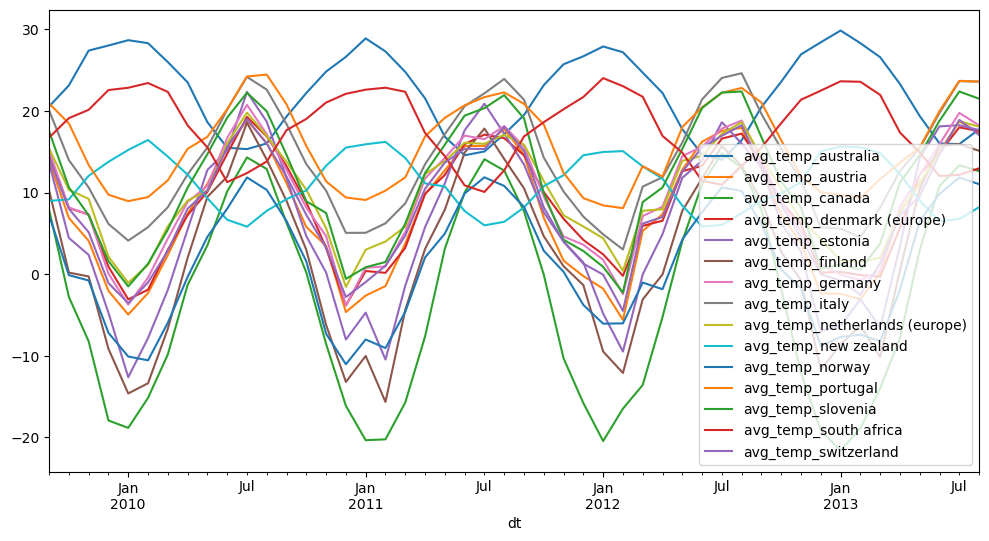

In [31]:
for temp in total_concat.columns:
    total_concat[temp].iloc[-(24*2):].plot(legend=True, figsize=(12,6))

# 

Because we can observe a lot of seasonality, we are going to use the following algorithms on this data: <br>
- ### SARIMA (Seasonal ARIMA)

# 

# SARIMA

In [32]:
#%pip install statsmodels
#%pip install pmdarima

In [33]:
# Import necessary libraries and modules
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

In [34]:
# result = seasonal_decompose(total['averagetemperature'], model='add', period=12)
# result.plot()

In [35]:
# There are still some NaNs here (last record), dropping them
total_concat.dropna(inplace=True)

#### Splitting Data into Train and Test

In [36]:
train = total_concat.iloc[:-273]
test = total_concat.iloc[-273:]

- Creating a function to compare the error with the mean of the data

In [37]:
# Comparing error and the mean of the df
def compare_error_mean(error, mean):
    percentage = round((100 / (mean/error)), 2)
    if percentage <= 5:
        return f'The model has an error of {percentage}, less than 5%, it is good.'
    else:
        return f'The model has an error of {percentage}%, it could be improved.' 

- Initialize dictionary where I'll save the tuples from auto_arima, so won't need to run them anymore (They take too long); 

In [38]:
# country_params = {}

# for i in range(len(all_countries)):
#     country_name = all_countries[i]['country'].unique()[0]
#     auto_ARIMA = auto_arima(all_countries[i]['avg_temp'], seasonal=True, m=12)
#     order = auto_ARIMA.order
#     seasonal_order = auto_ARIMA.seasonal_order
#     country_params[country_name] = {'order': order, 
#                                      'seasonal_order': seasonal_order}

- Saving json file externally

In [39]:
# with open('country_params.json', 'w', encoding='utf-8') as file:
#     json.dump(country_params, file, ensure_ascii=False, indent=4)

- Opening and using the file

In [40]:
# Opening the file

f = open('country_params.json')
params = json.load(f)

# f.close()

Before Running the model for each country, I want to find my predictions for the **global Average Temperatures**.

In [41]:
# g_parameters = auto_arima(total_avg, seasonal=True, m=12)

In [42]:
# Defining orders
# g_order = (1,1,2)
# s_order = (2,0,2,12)

g_order = (1,1,2) # g_parameters.order
g_s_order = (2,0,2,12) # g_parameters.seasonal_order

In [43]:
# Train, test split
g_train = total_avg.iloc[:-60]['global_avg']
g_test = total_avg.iloc[-60:]['global_avg']

In [44]:
# create model
g_model = SARIMAX(g_train, order=g_order, seasonal_order=g_s_order)
g_model.initialize_approximate_diffuse()
g_results = g_model.fit(disp=0)

In [45]:
# Define start and end
g_start = len(g_train)
g_end = len(g_train) + len(g_test) - 1

In [46]:
# Prediction and forecast for 20 years
g_predictions = g_results.predict(g_start, g_end, typ='levels').rename(f"SARIMA predictions for global average")
g_fcast = g_results.predict(len(total_avg)-1, len(total_avg) + 240, typ='levels').rename(f"SARIMA forecast for global average")

In [47]:
# Evaluation
g_error = rmse(g_test, g_predictions)
g_mean = round(g_test.mean(), 2)
compare_error_mean(g_error, g_mean)
print(f'Error: ', g_error)
print(f'Mean: ', g_mean)

Error:  0.28627286945993874
Mean:  19.51


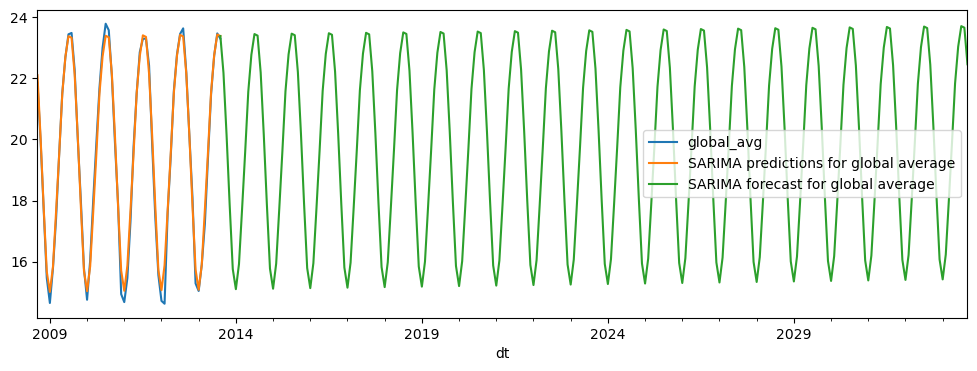

10 years Mean temperatures for the global average: 


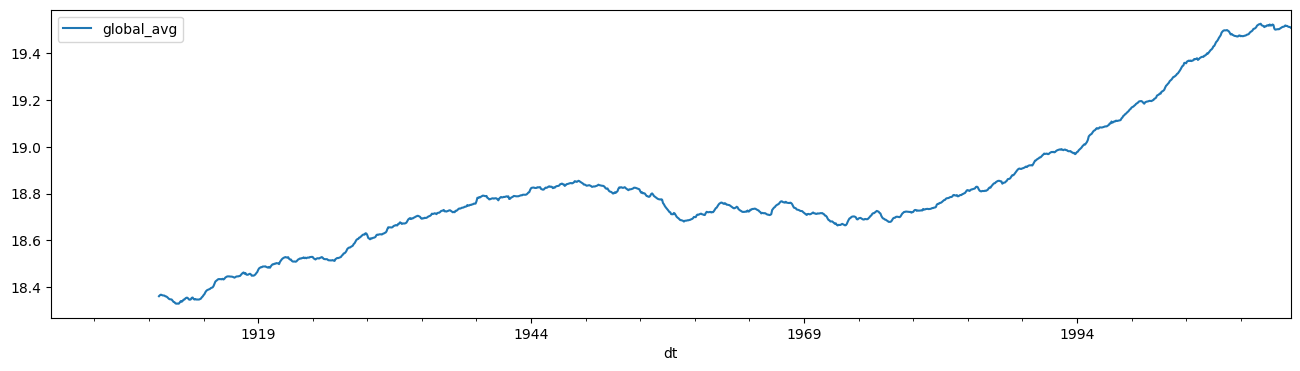

Yearly predictions average for the global average: 


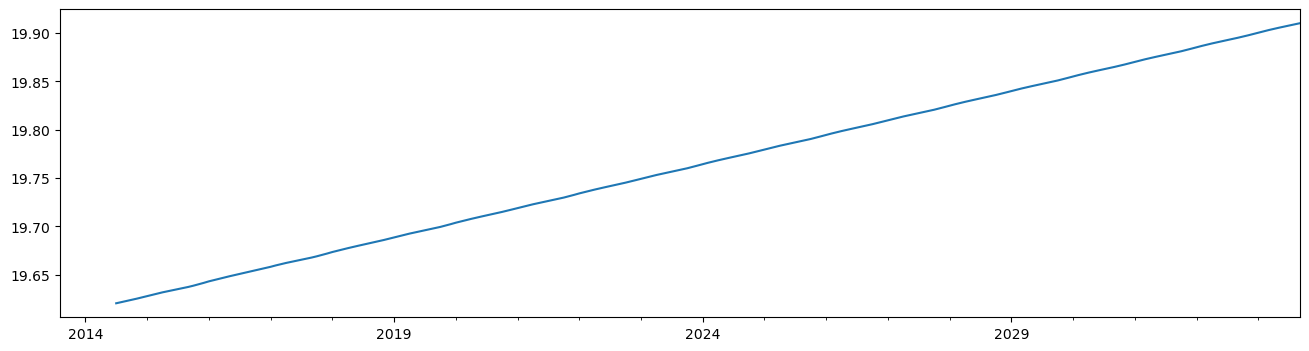

In [48]:
g_test.plot(legend=True, figsize=(12,4))
g_predictions.plot(legend=True)
#     g_train.plot(legend=True)
g_fcast.plot(legend=True)
plt.show()

# Plot mean for each 10yrs for existing data
print(f"10 years Mean temperatures for the global average: ")
total_avg.rolling(window=120).mean().plot(figsize=(16,4))
plt.show()

# Plot yearly mean of predictions
print(f"Yearly predictions average for the global average: ")
g_fcast.rolling(window=12).mean().plot(figsize=(16,4))
plt.show()

- Write a loop going through all dataframes
- For each loop, create and save (can save into a JSON!)
    - train, test
    - model
    - results
    - predictions
    - error
    - mean
- Plot Real Data against predictions (remember to plt.show() in the loop!)

Australia
Error:  0.8
Mean:  22.29


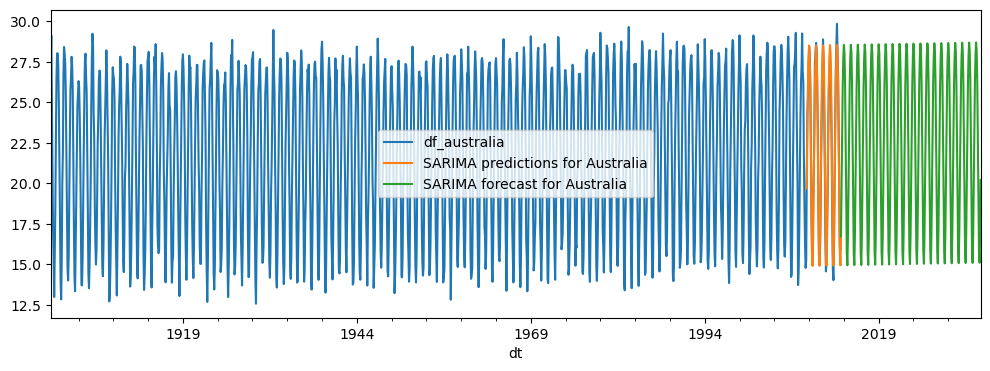

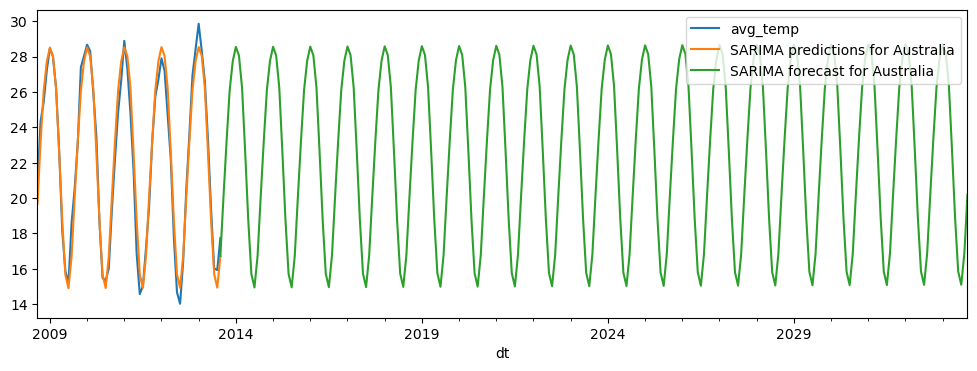

10 years Mean temperatures for Australia vs. Global average: 


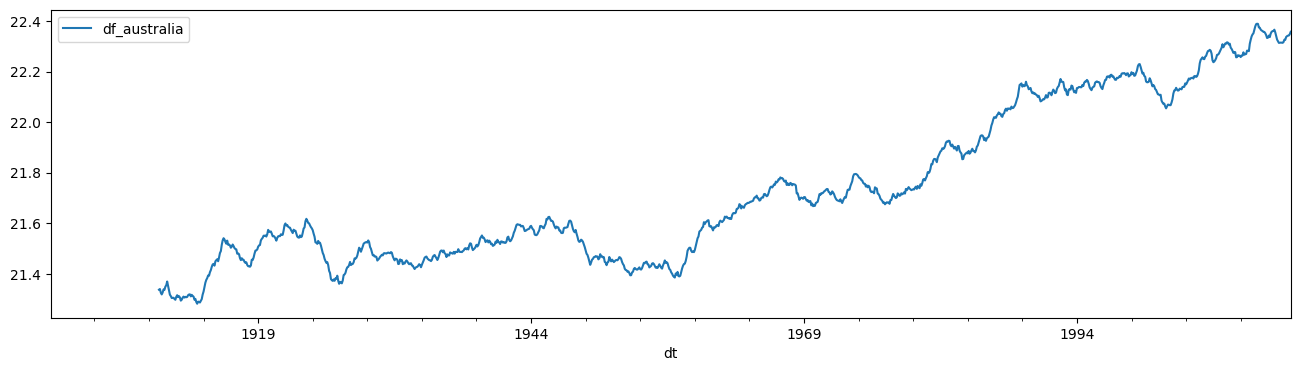

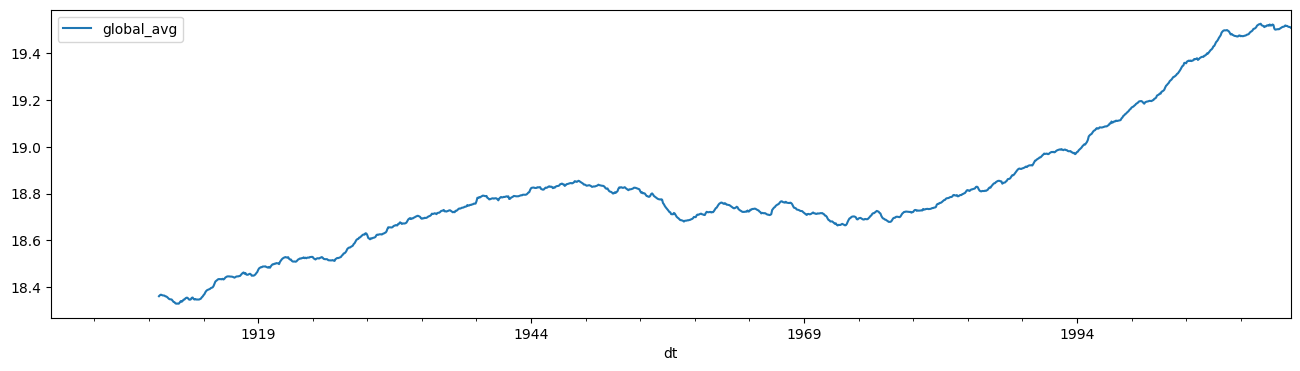

Yearly predictions average for Australia vs. Global average: 


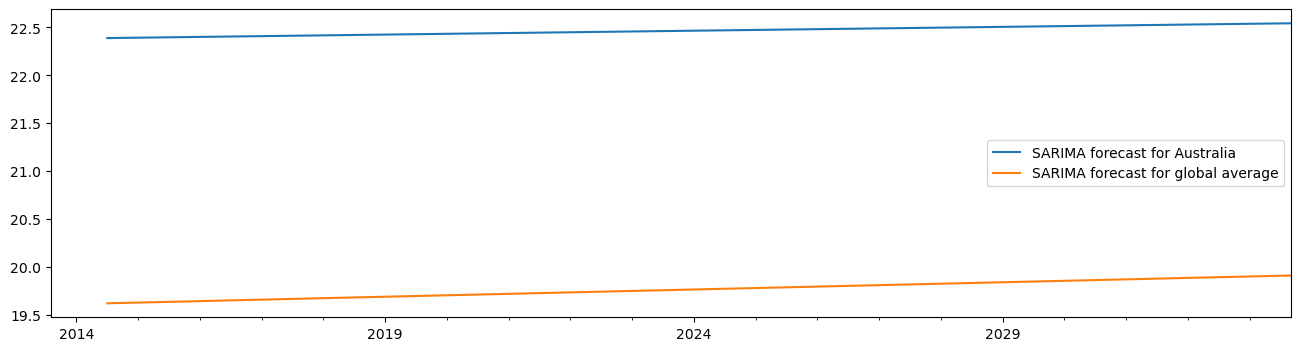



Austria
Error:  1.52
Mean:  7.37


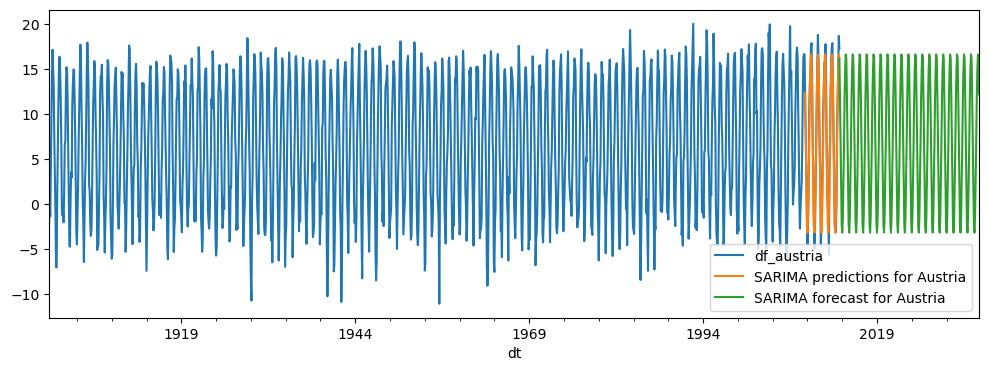

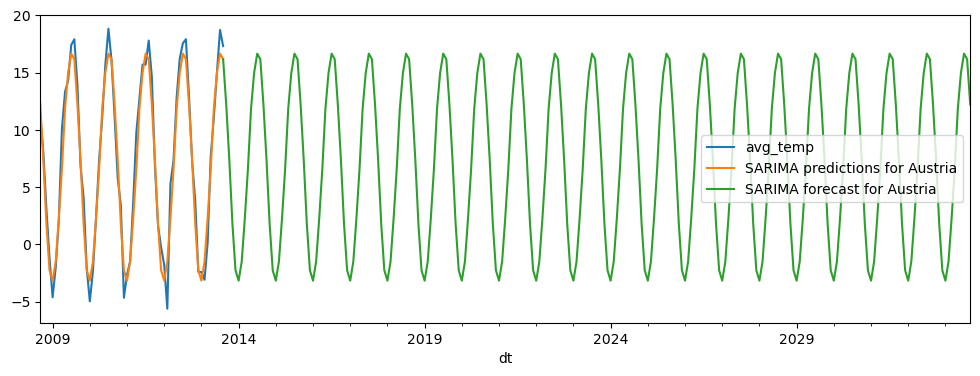

10 years Mean temperatures for Austria vs. Global average: 


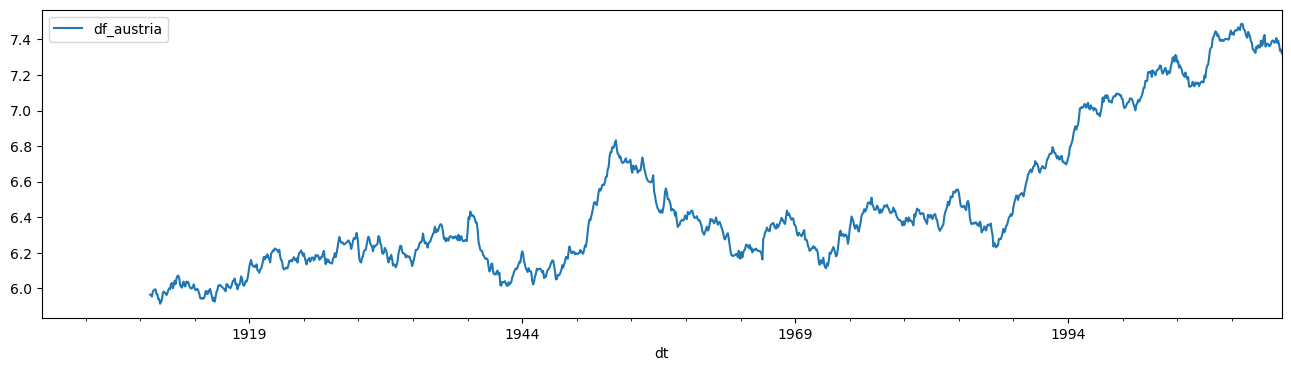

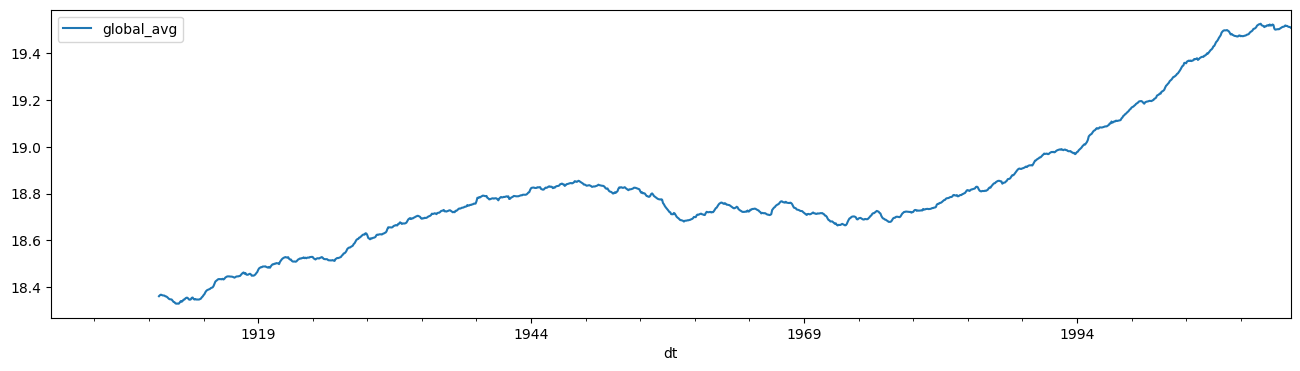

Yearly predictions average for Austria vs. Global average: 


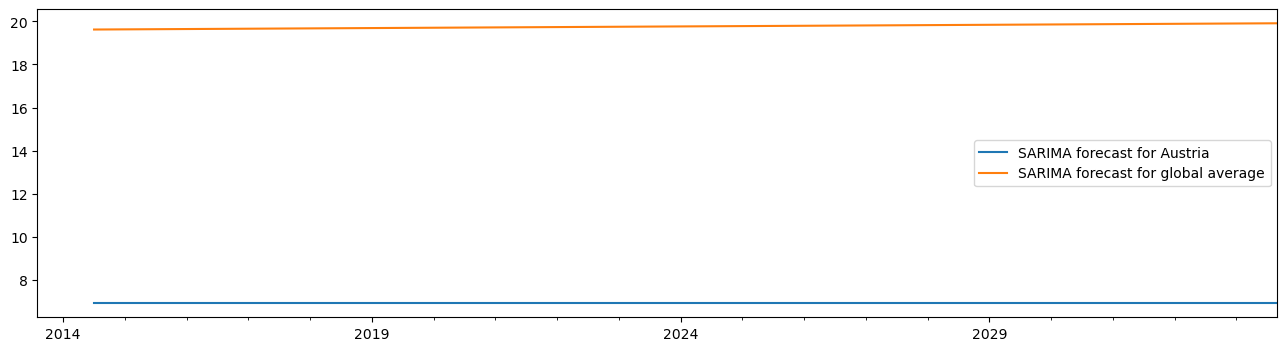



Canada
Error:  2.04
Mean:  -3.33


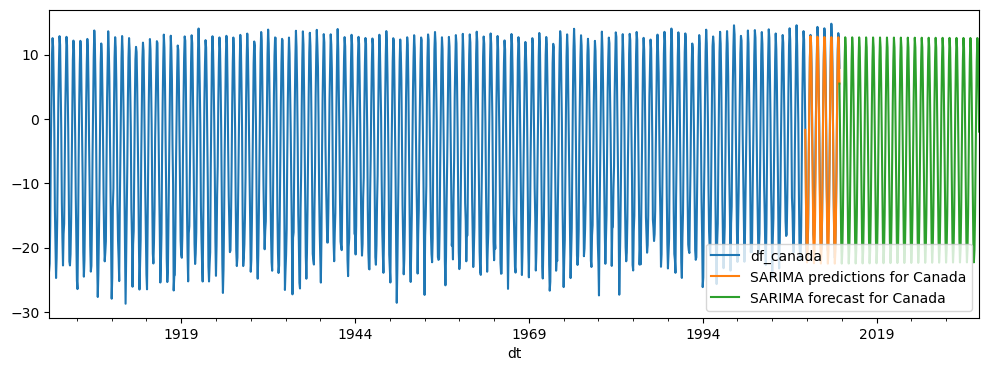

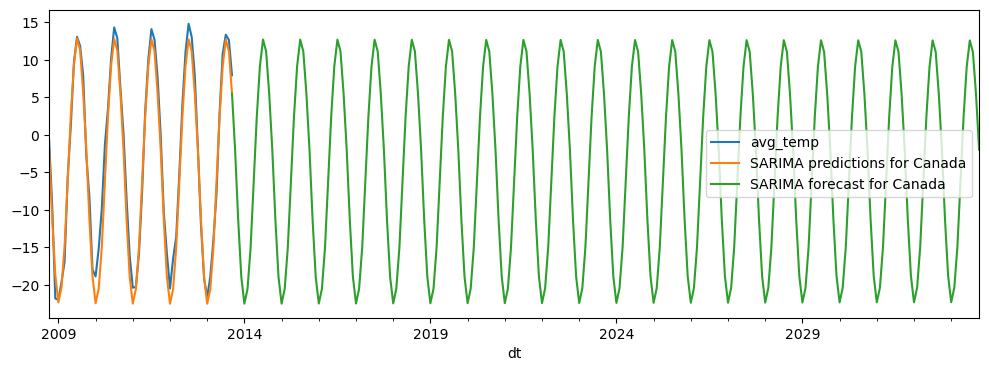

10 years Mean temperatures for Canada vs. Global average: 


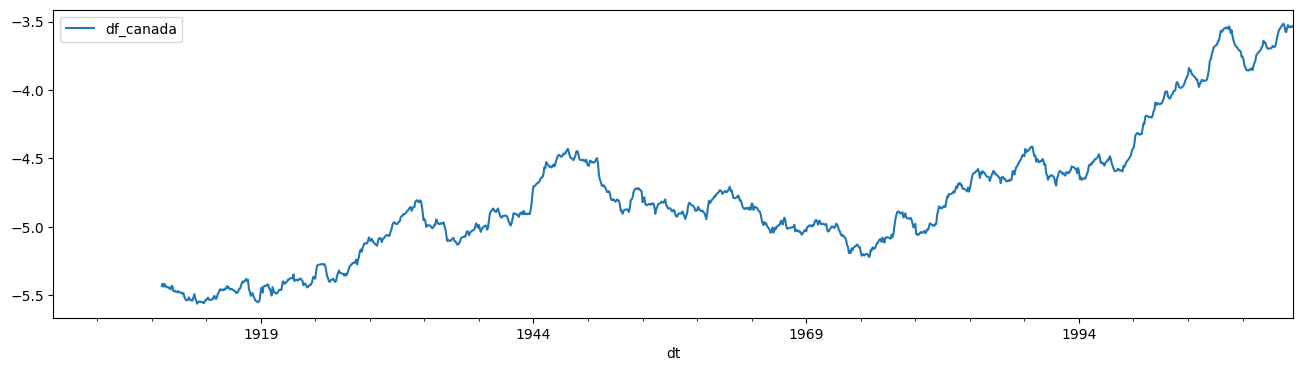

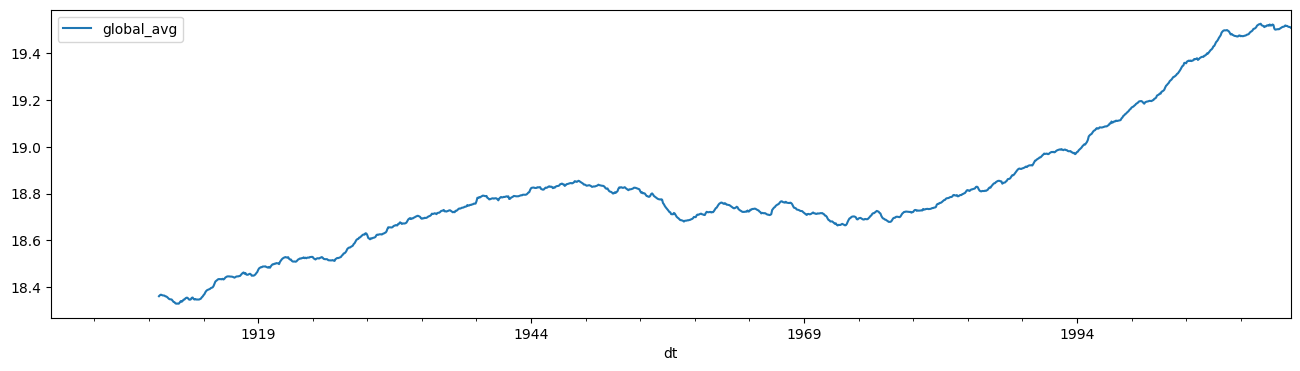

Yearly predictions average for Canada vs. Global average: 


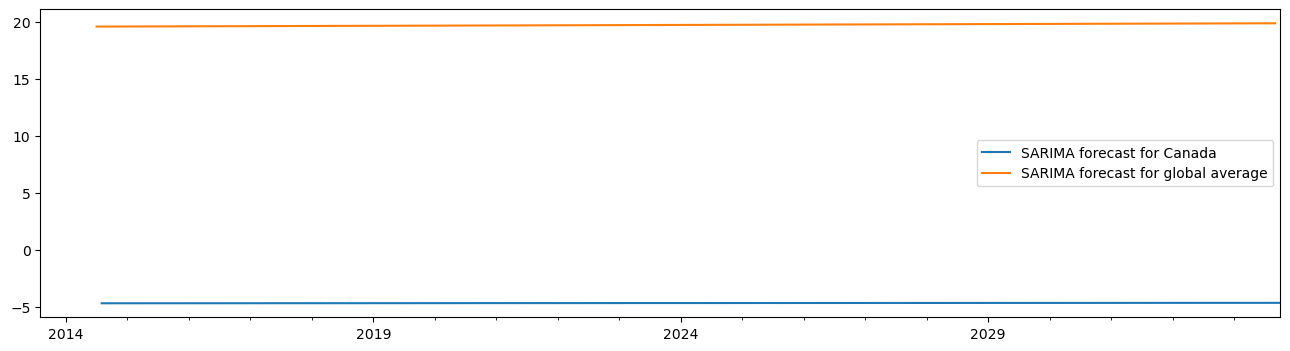



Denmark (Europe)
Error:  1.75
Mean:  8.52


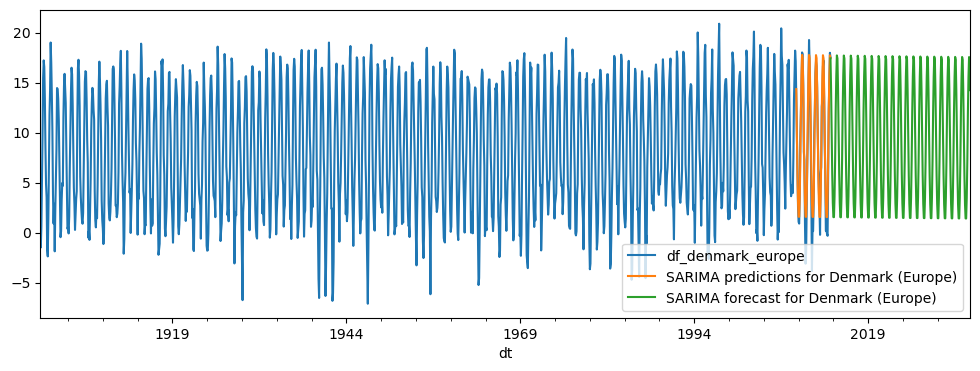

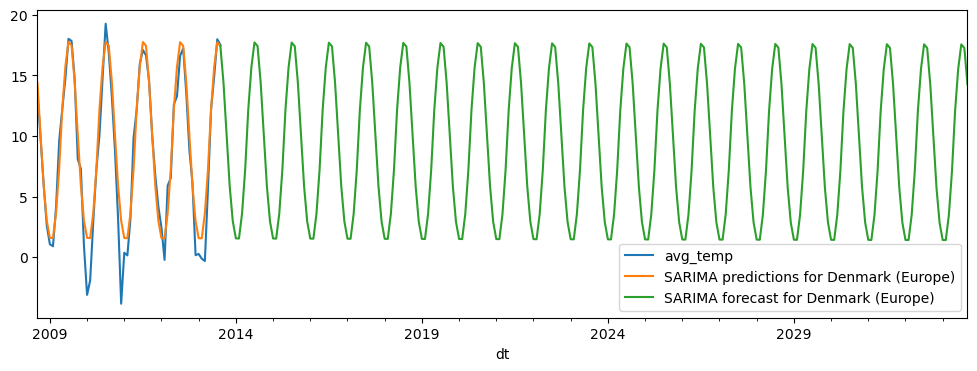

10 years Mean temperatures for Denmark (Europe) vs. Global average: 


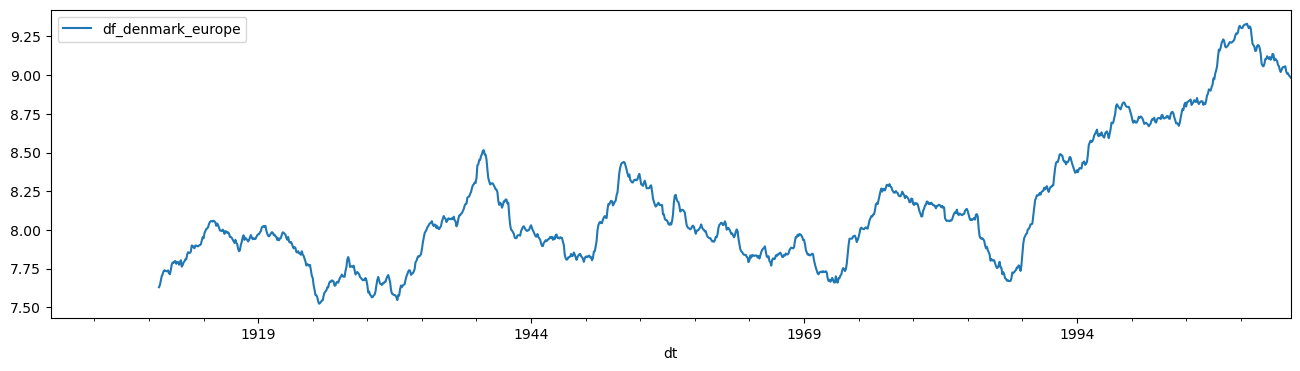

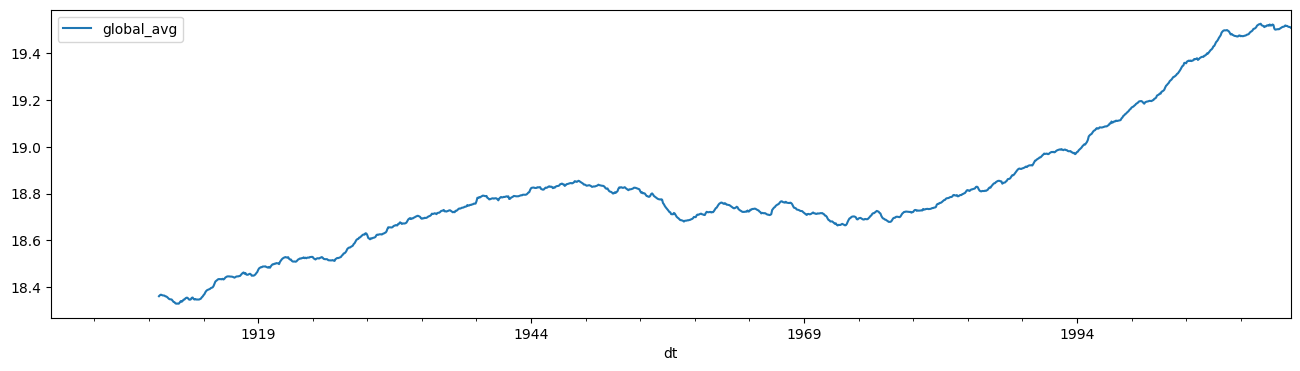

Yearly predictions average for Denmark (Europe) vs. Global average: 


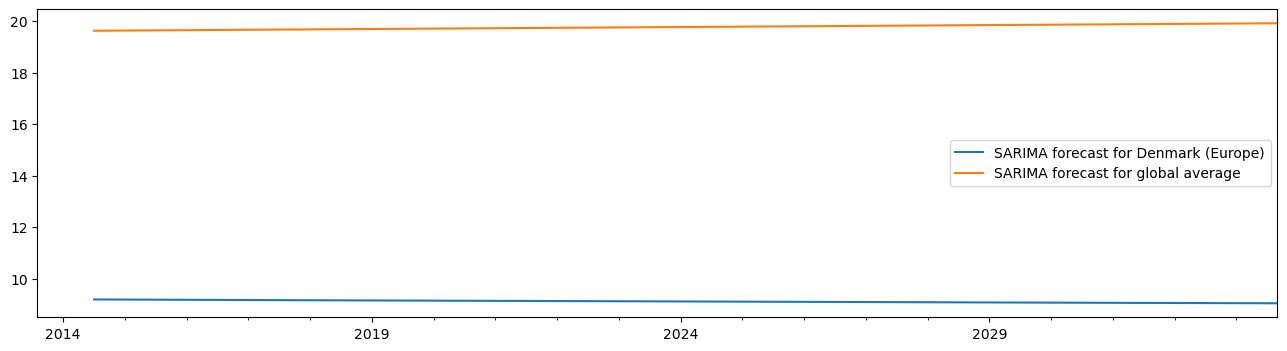



Estonia
Error:  2.39
Mean:  5.97


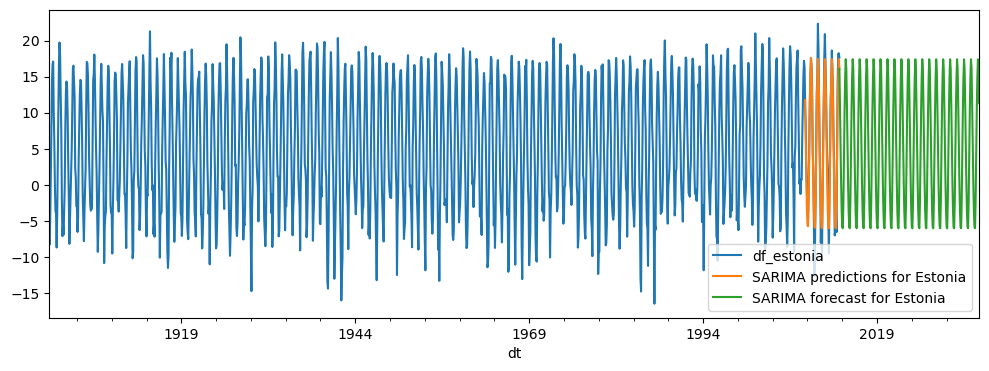

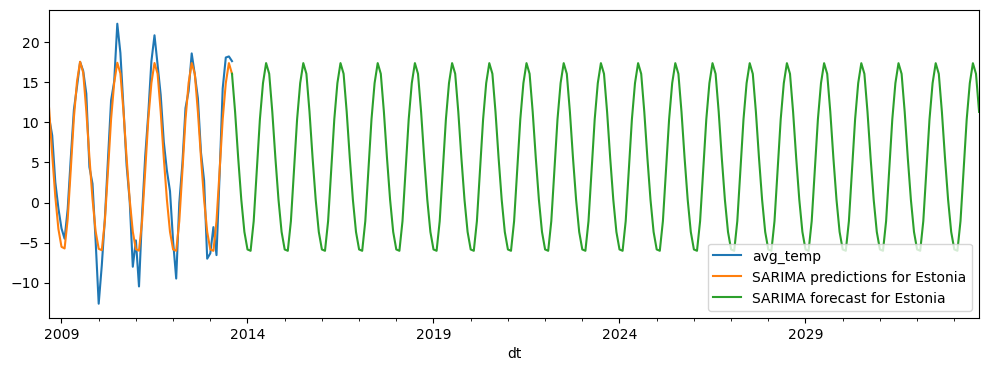

10 years Mean temperatures for Estonia vs. Global average: 


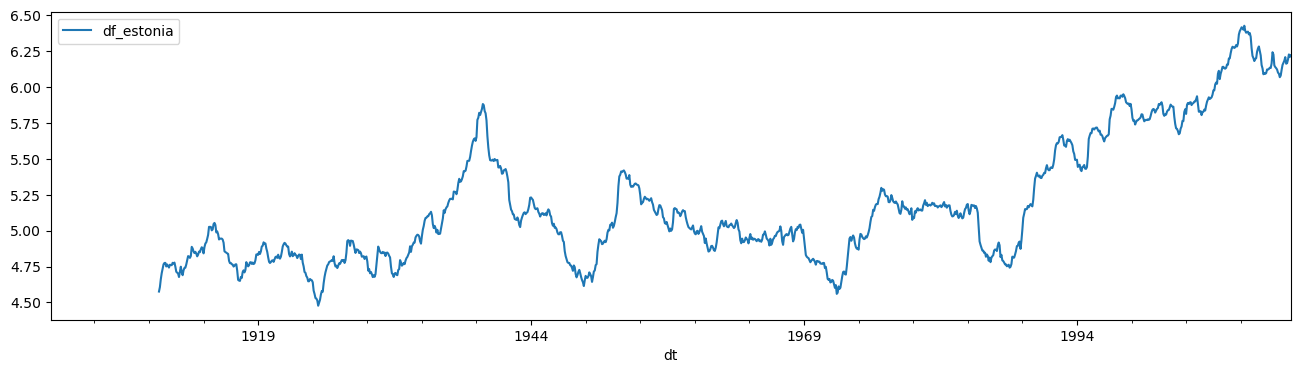

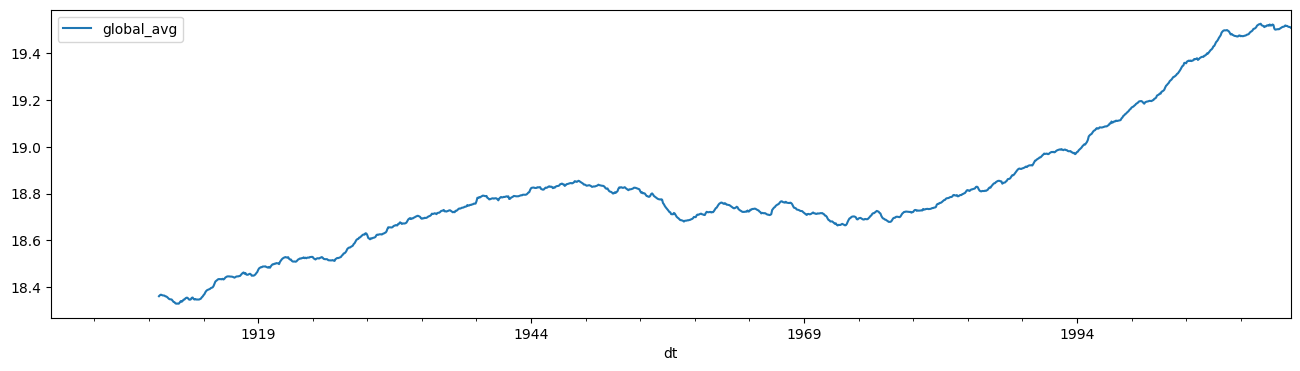

Yearly predictions average for Estonia vs. Global average: 


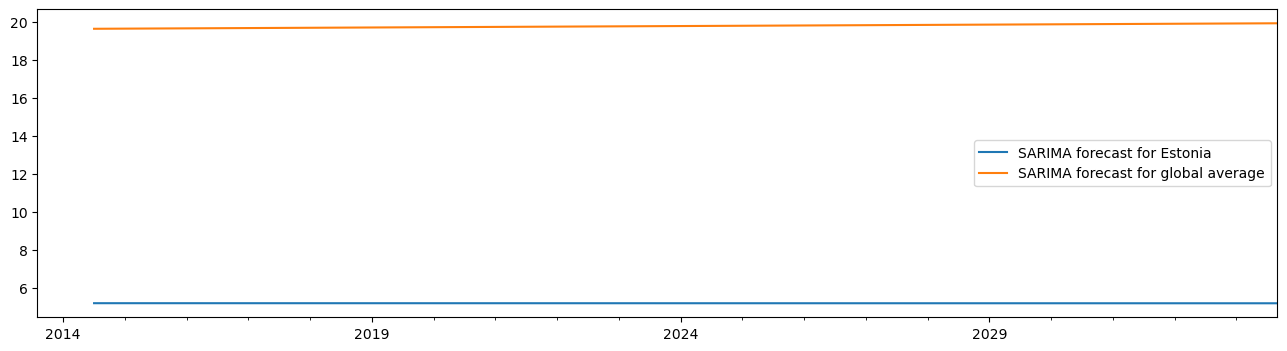



Finland
Error:  3.45
Mean:  2.46


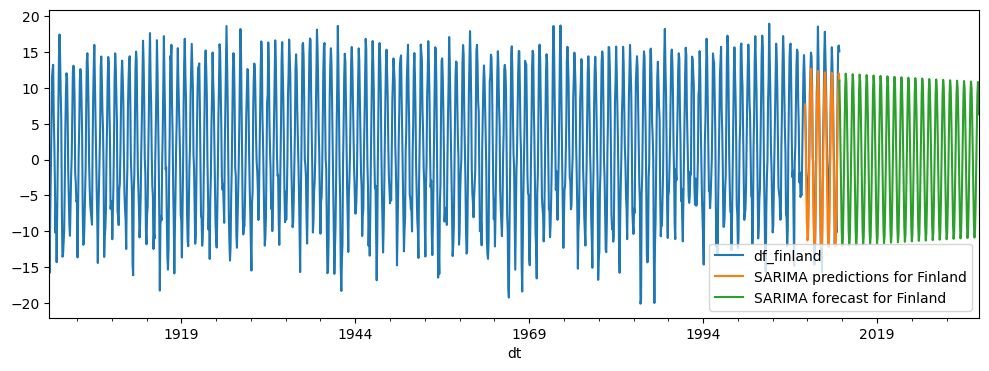

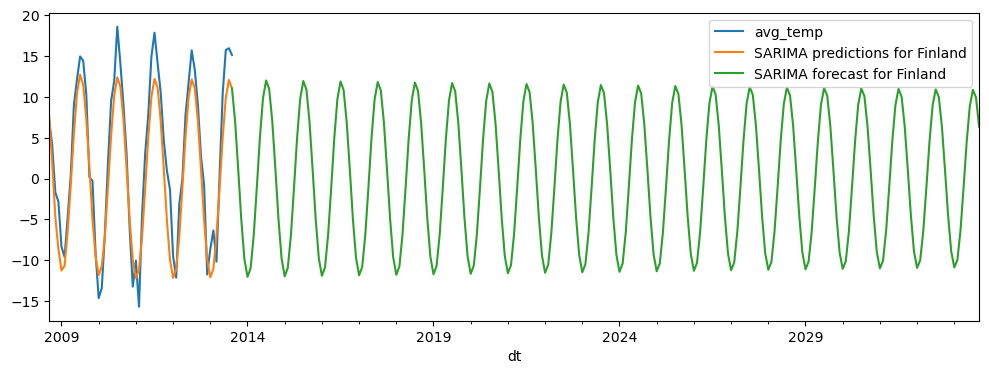

10 years Mean temperatures for Finland vs. Global average: 


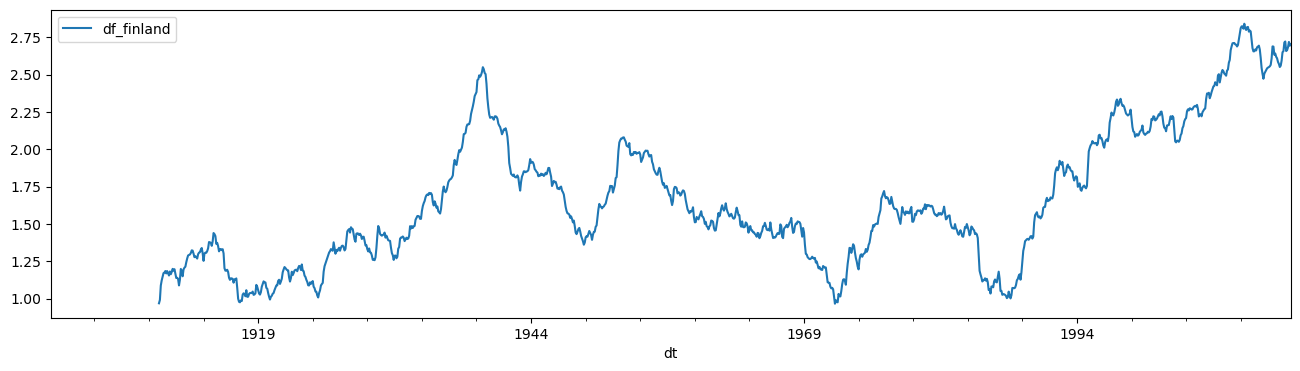

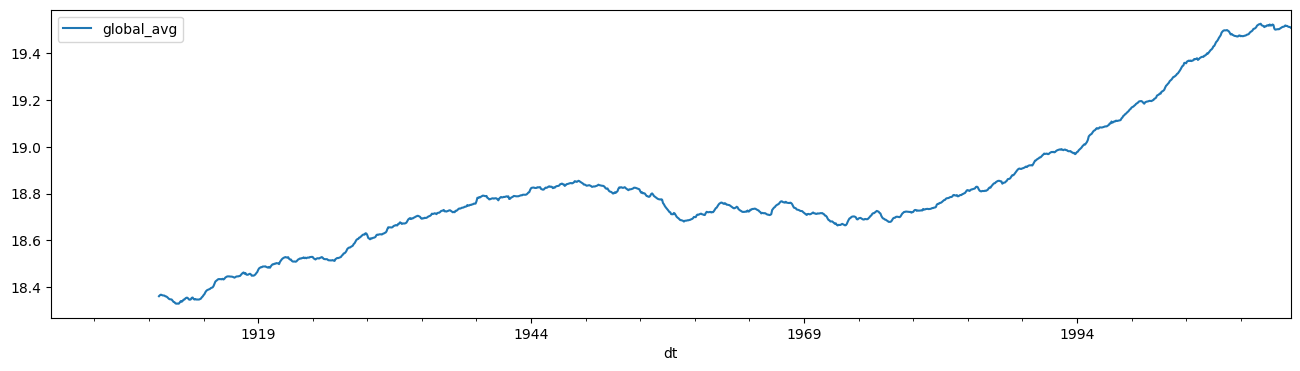

Yearly predictions average for Finland vs. Global average: 


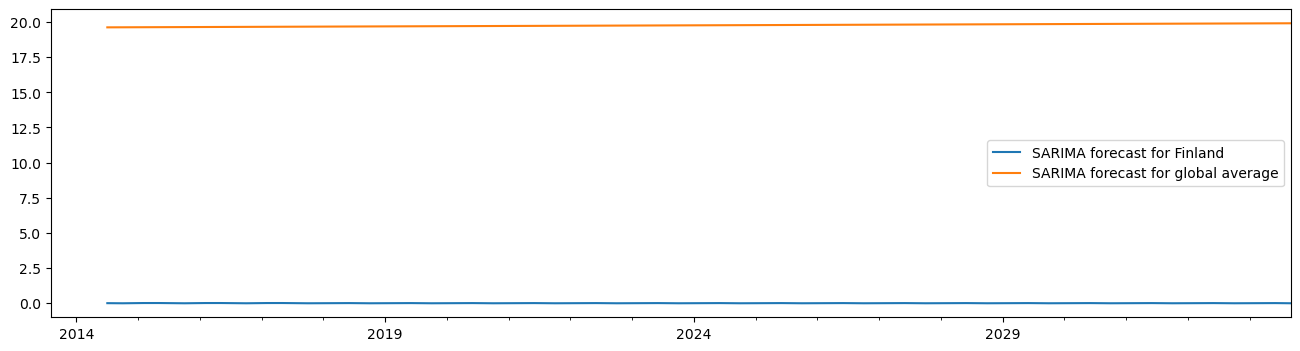



Germany
Error:  1.76
Mean:  8.98


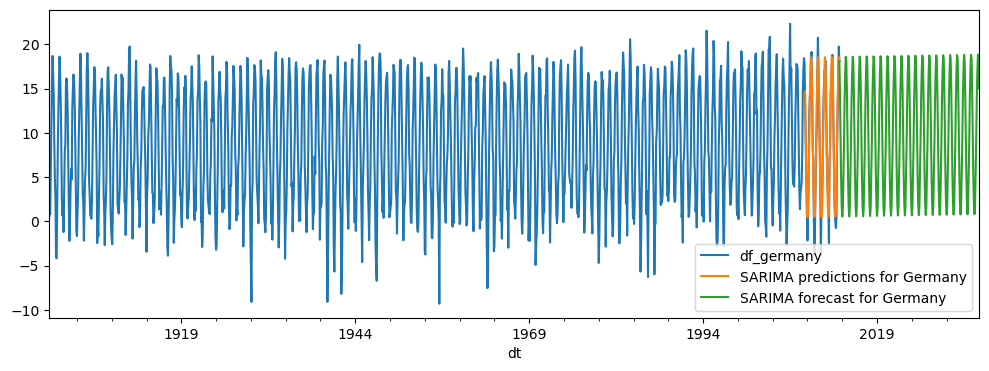

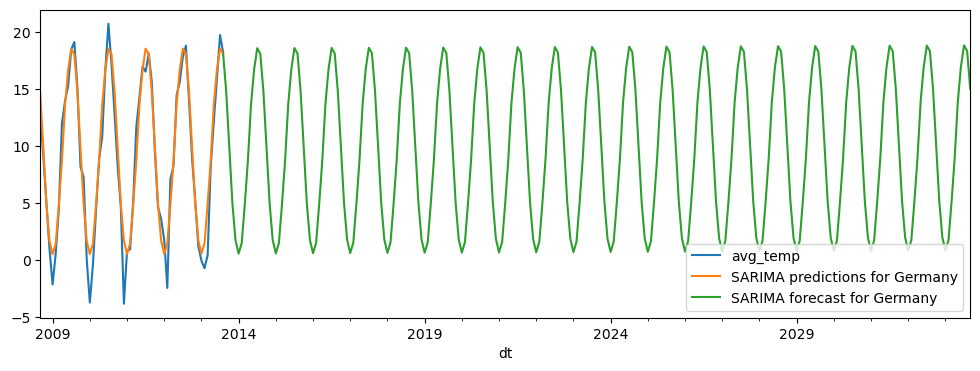

10 years Mean temperatures for Germany vs. Global average: 


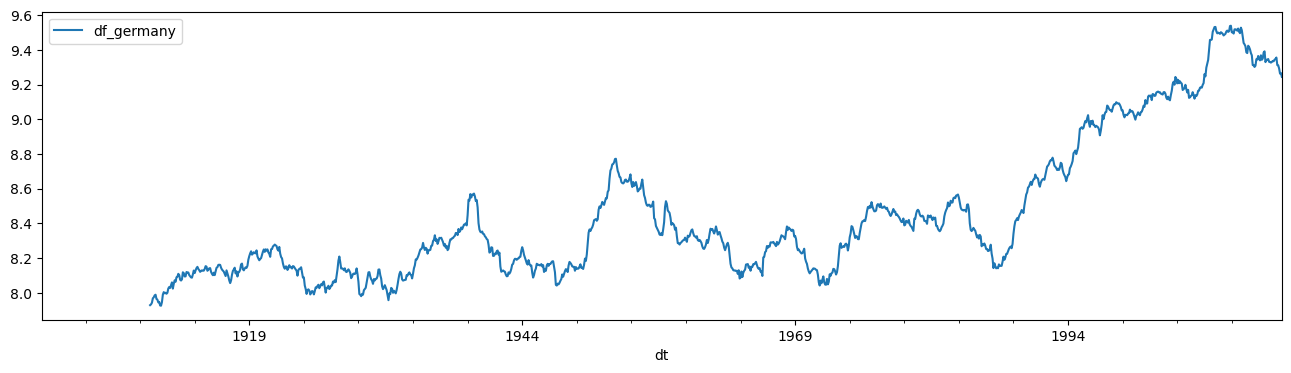

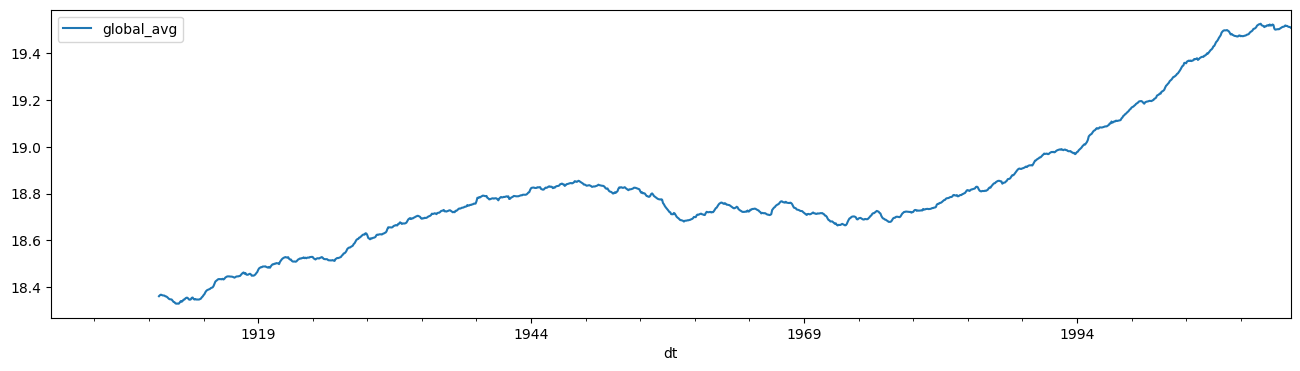

Yearly predictions average for Germany vs. Global average: 


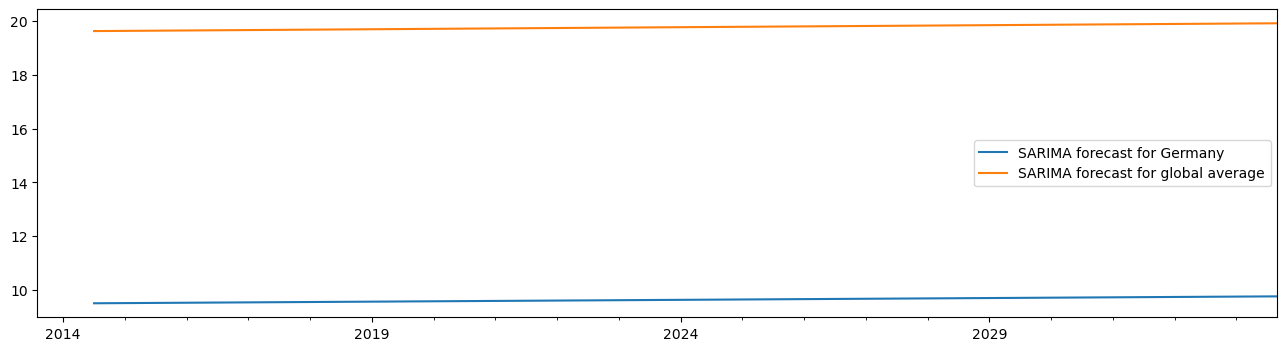



Italy
Error:  1.02
Mean:  13.84


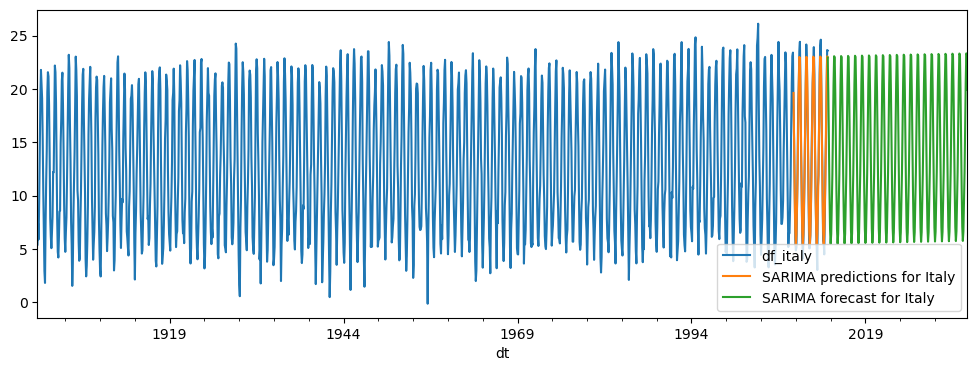

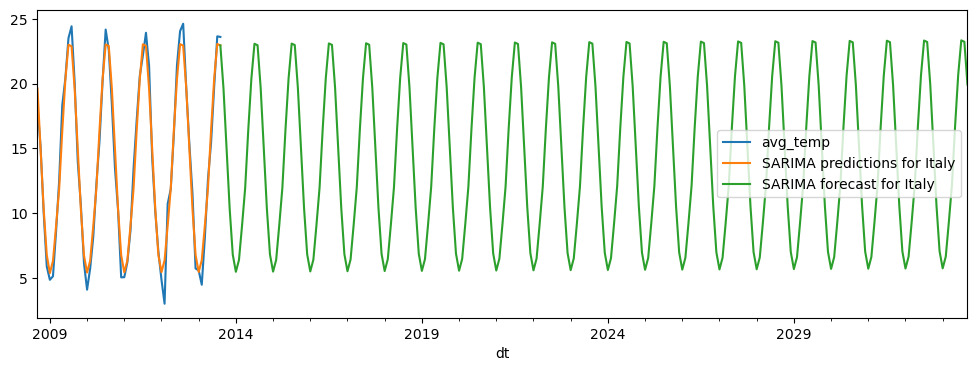

10 years Mean temperatures for Italy vs. Global average: 


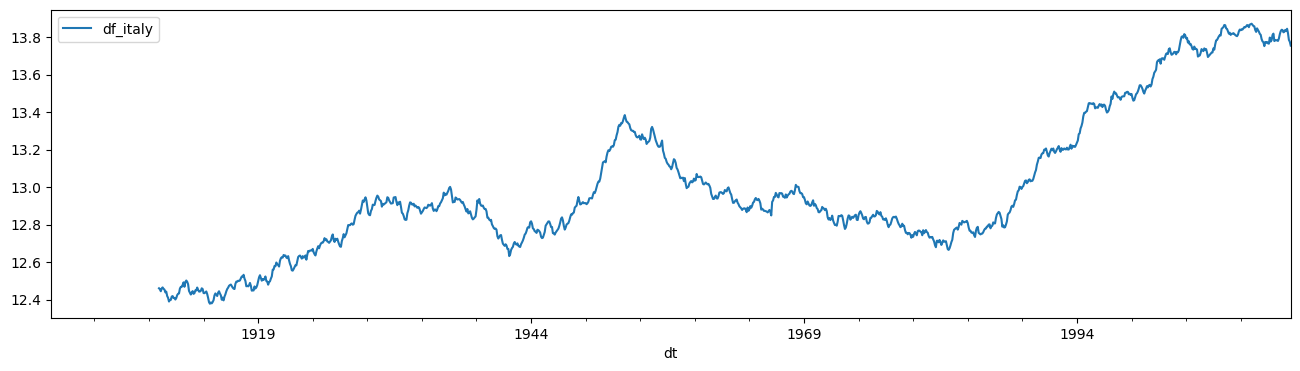

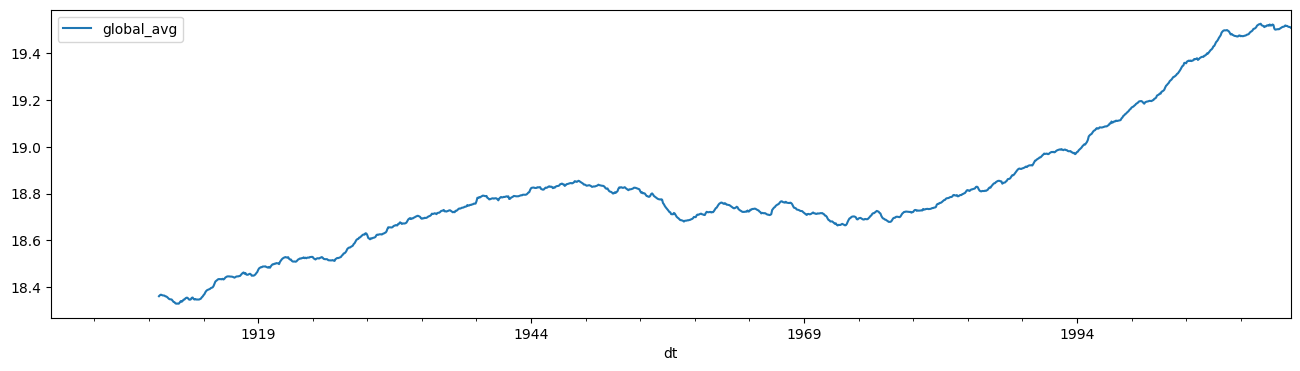

Yearly predictions average for Italy vs. Global average: 


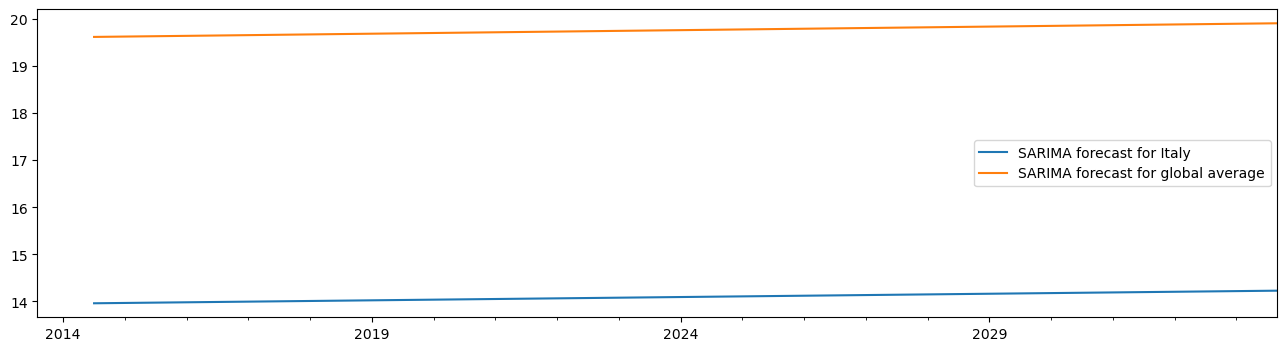



Netherlands (Europe)
Error:  1.79
Mean:  9.79


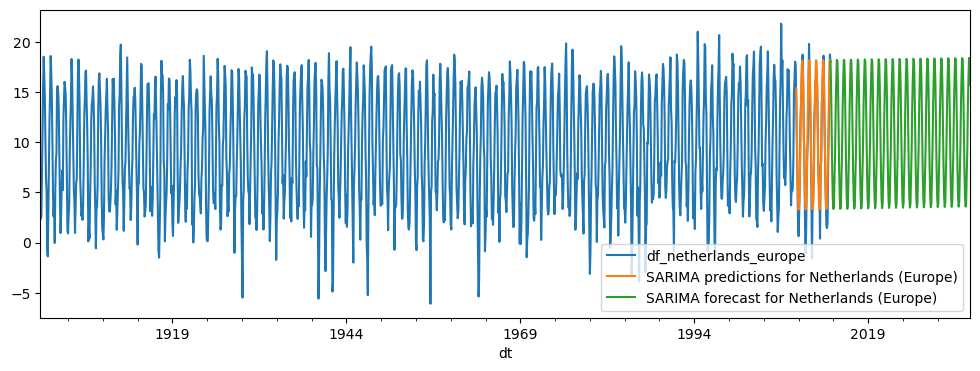

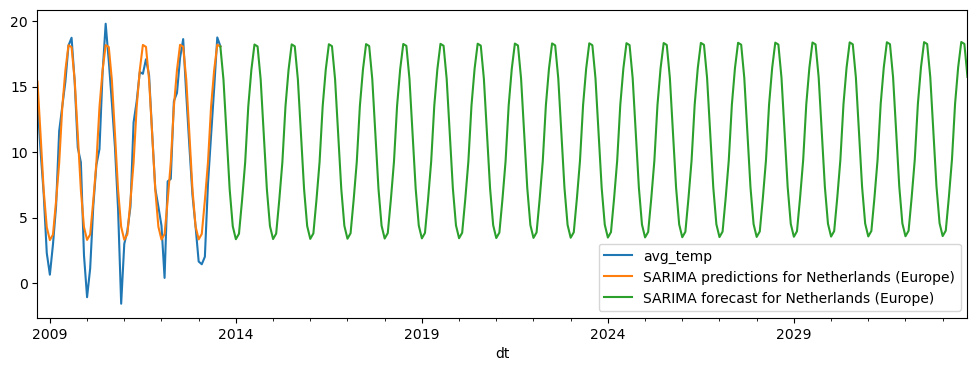

10 years Mean temperatures for Netherlands (Europe) vs. Global average: 


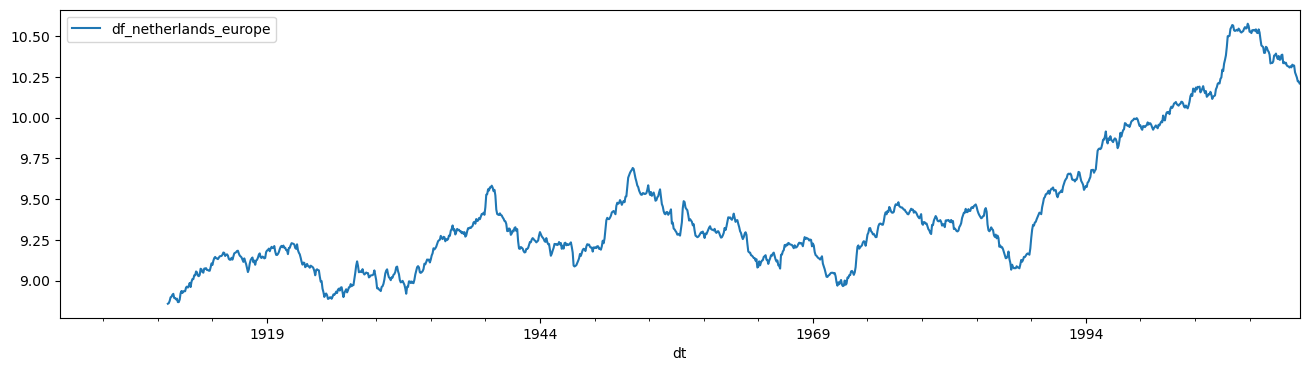

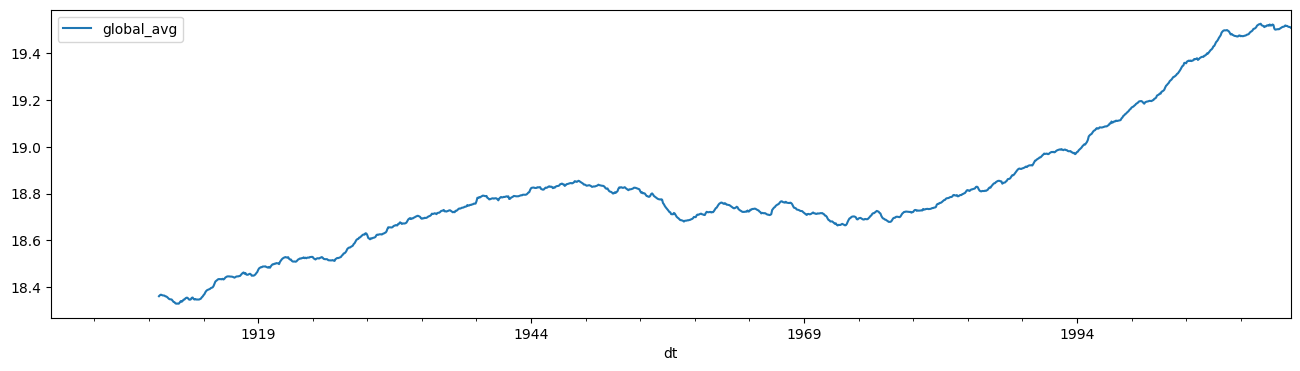

Yearly predictions average for Netherlands (Europe) vs. Global average: 


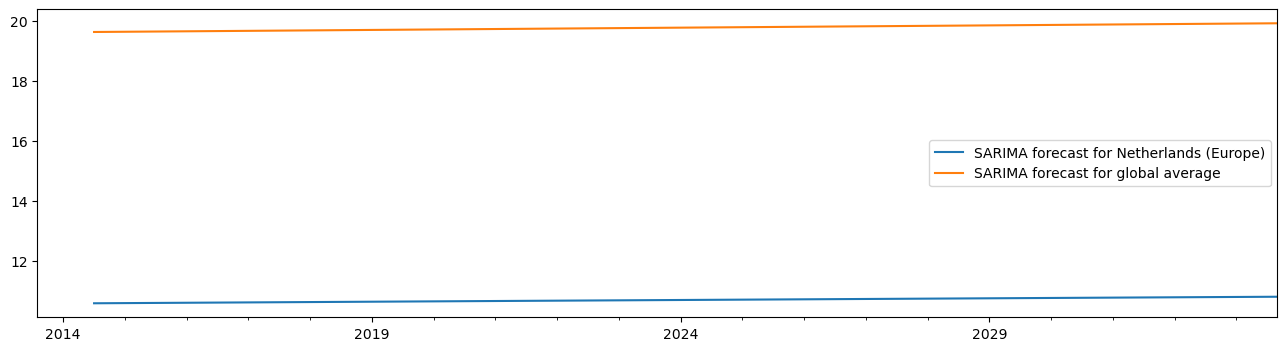



New Zealand
Error:  0.69
Mean:  11.02


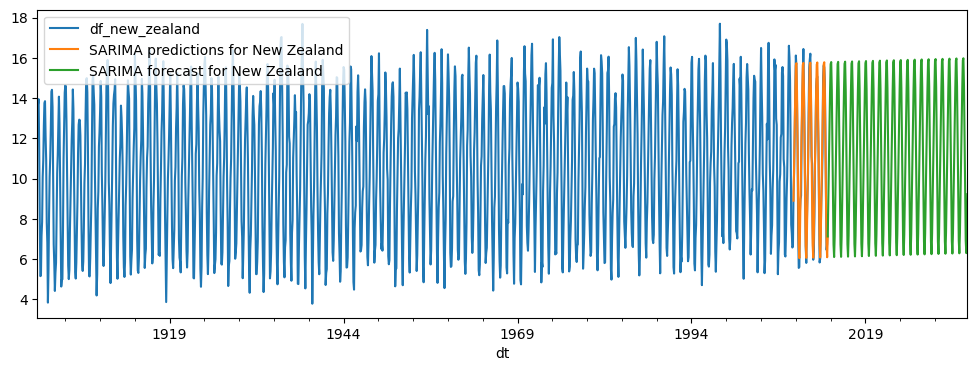

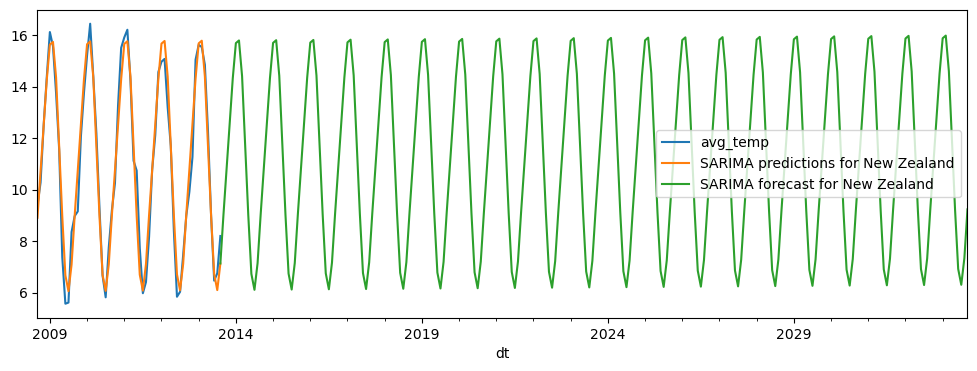

10 years Mean temperatures for New Zealand vs. Global average: 


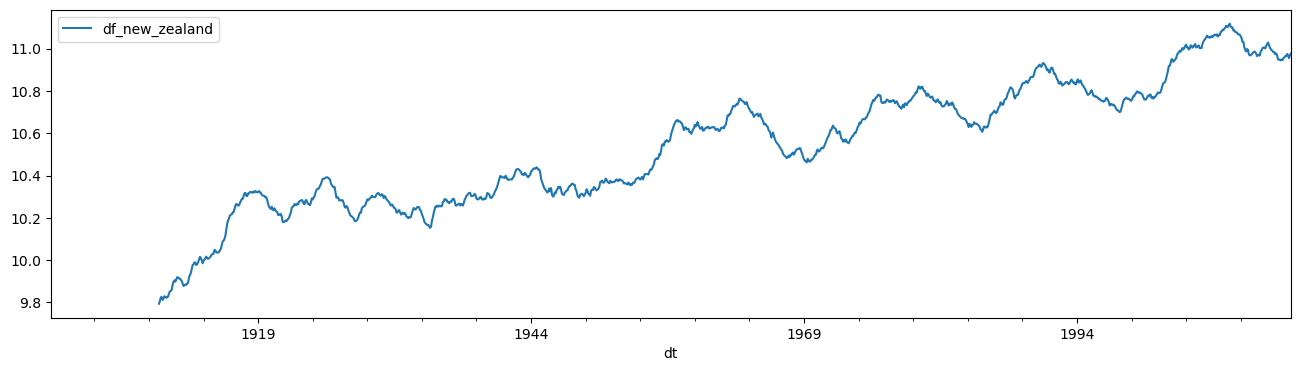

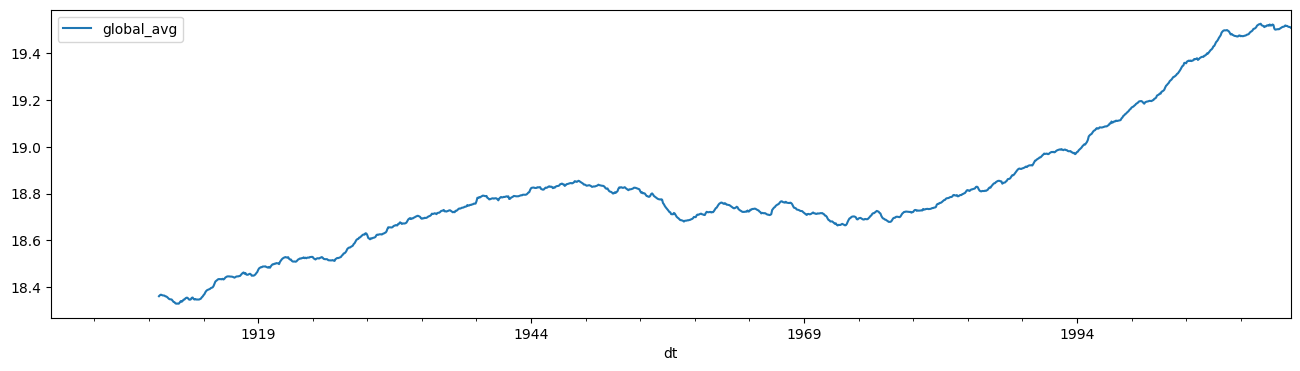

Yearly predictions average for New Zealand vs. Global average: 


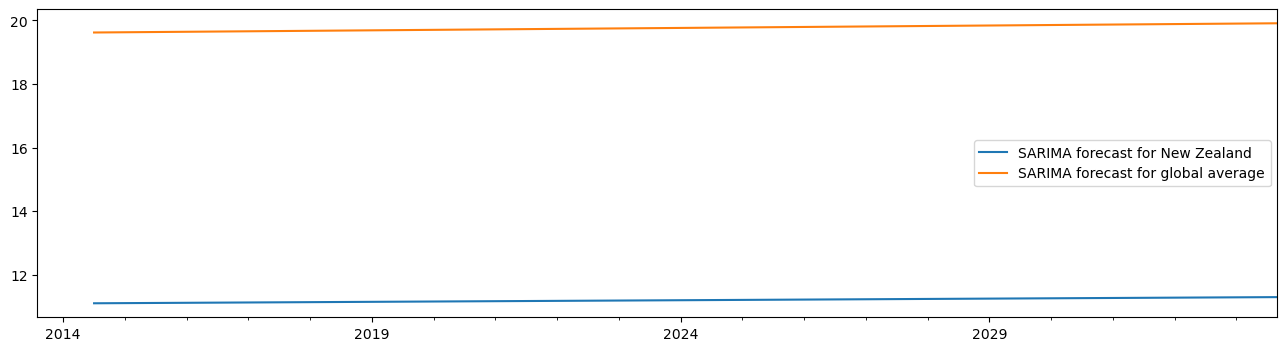



Norway
Error:  1.69
Mean:  1.11


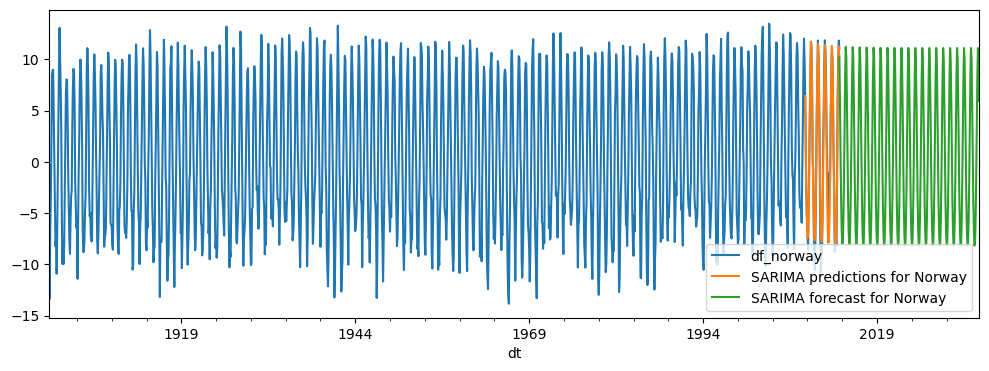

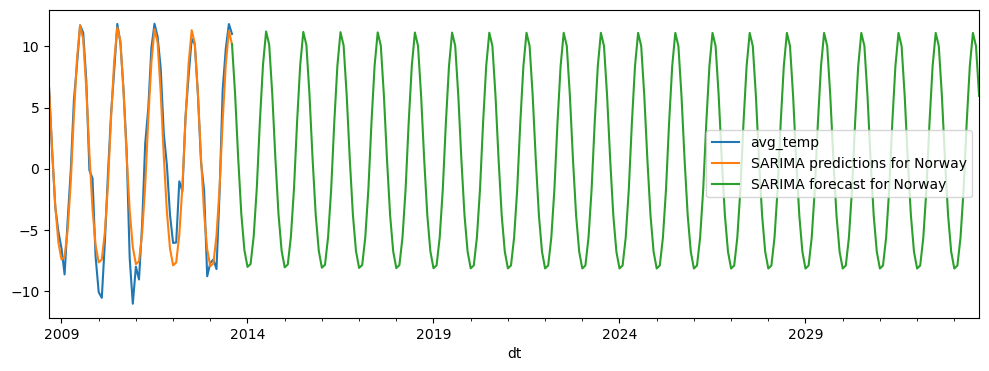

10 years Mean temperatures for Norway vs. Global average: 


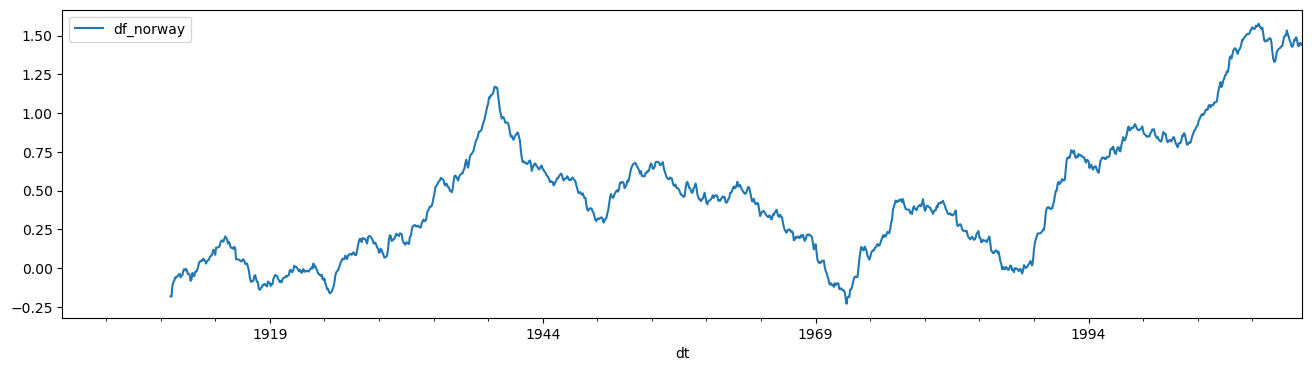

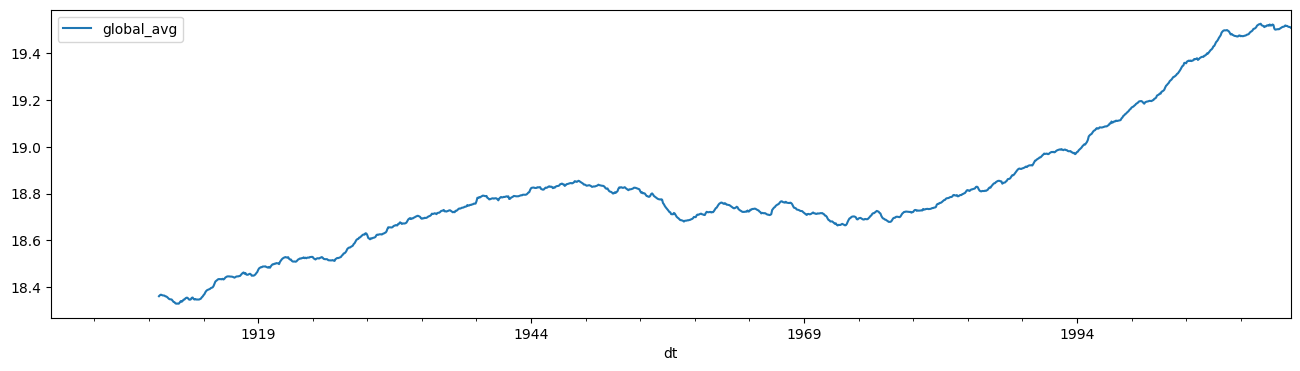

Yearly predictions average for Norway vs. Global average: 


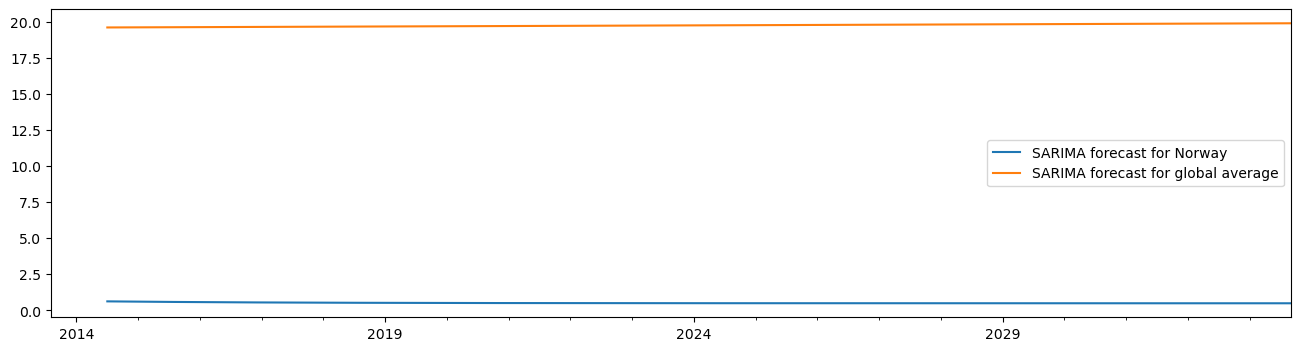



Portugal
Error:  1.11
Mean:  15.65


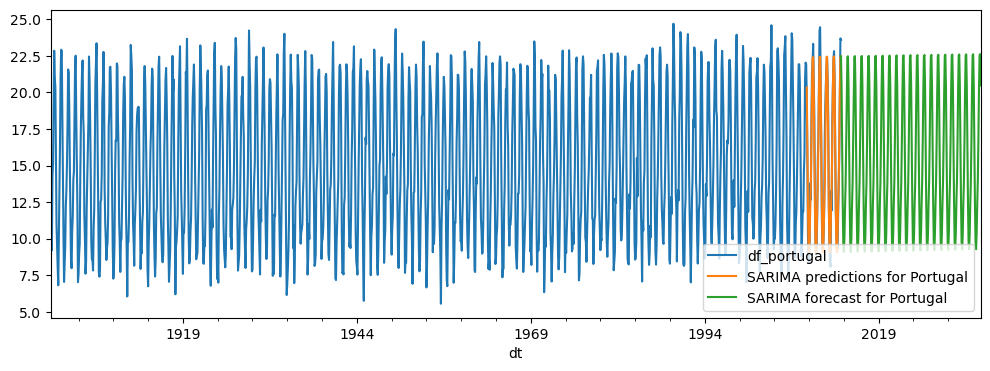

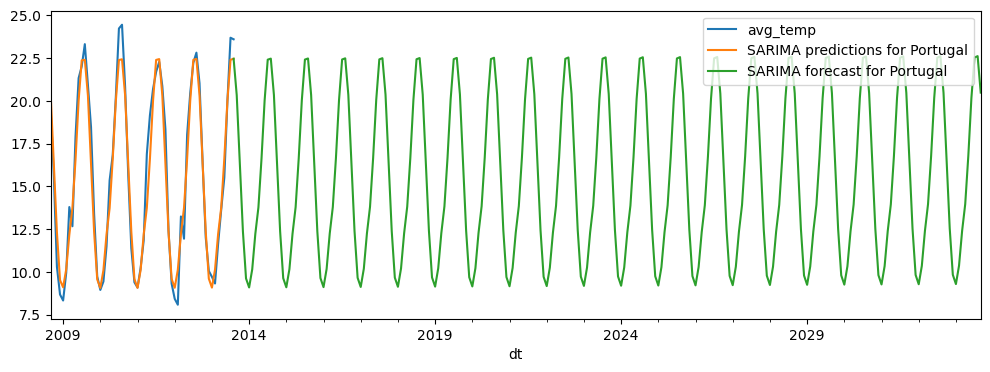

10 years Mean temperatures for Portugal vs. Global average: 


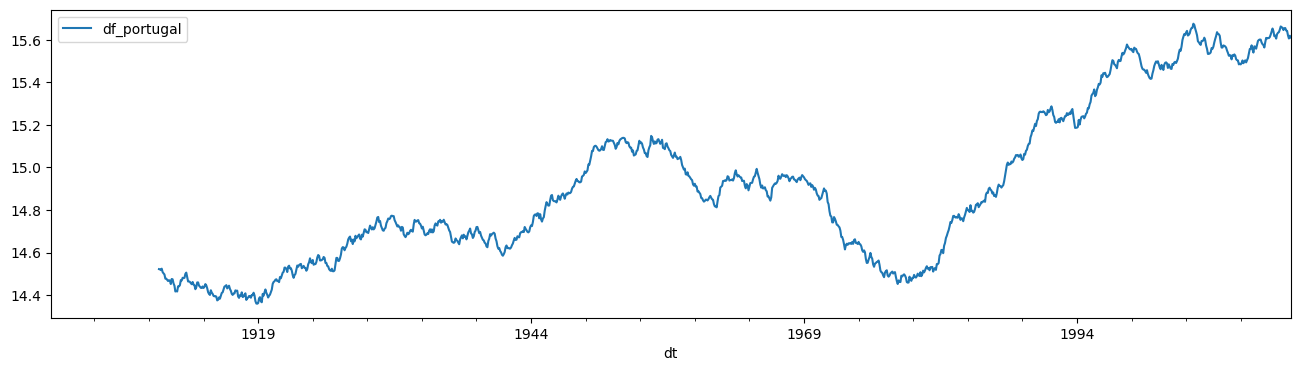

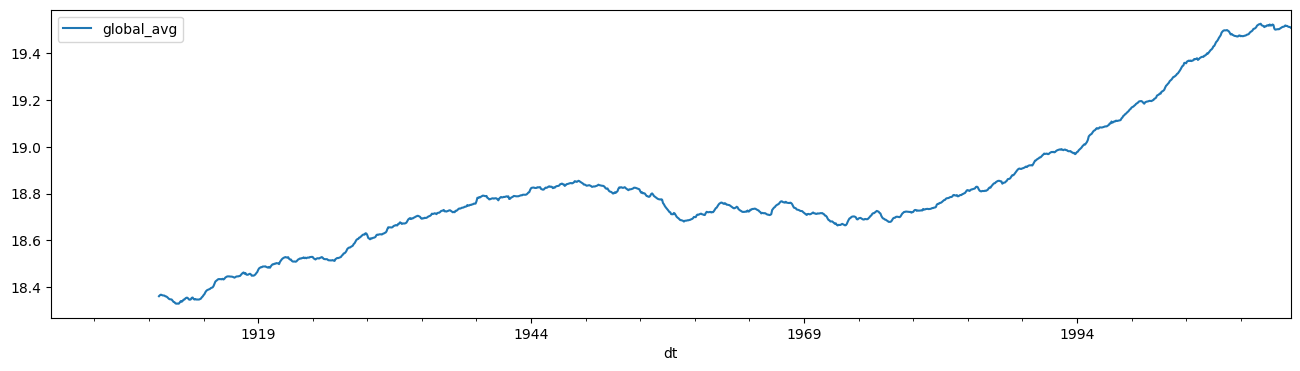

Yearly predictions average for Portugal vs. Global average: 


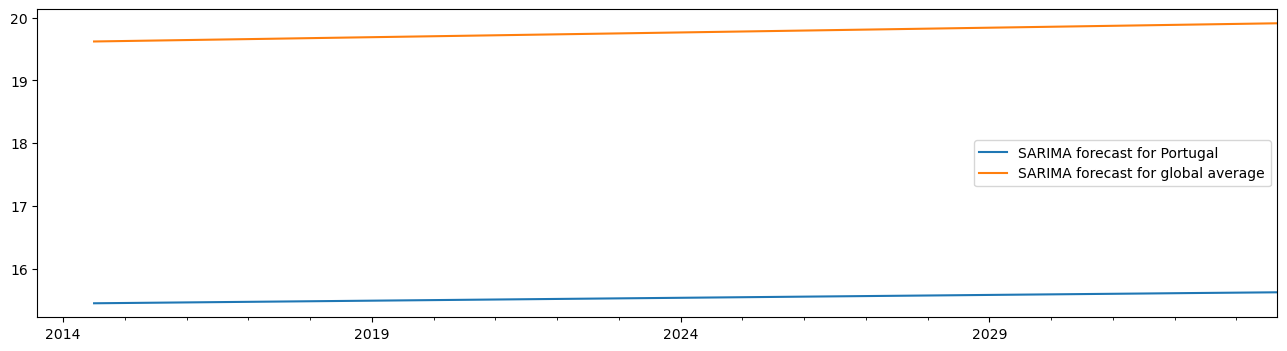



Slovenia
Error:  1.44
Mean:  10.93


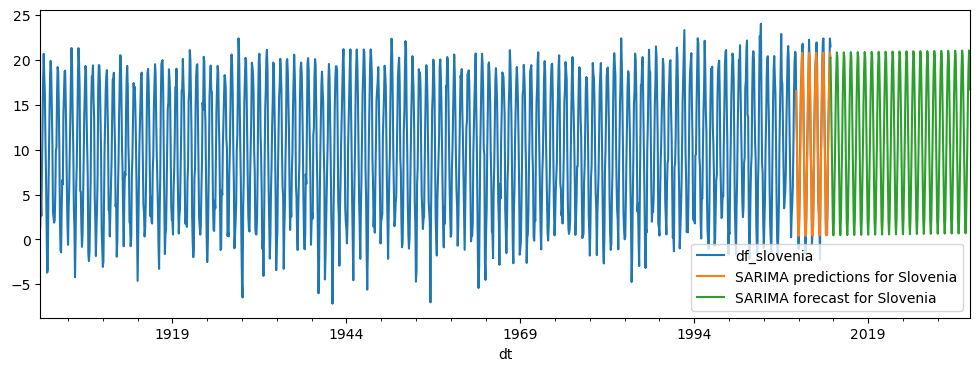

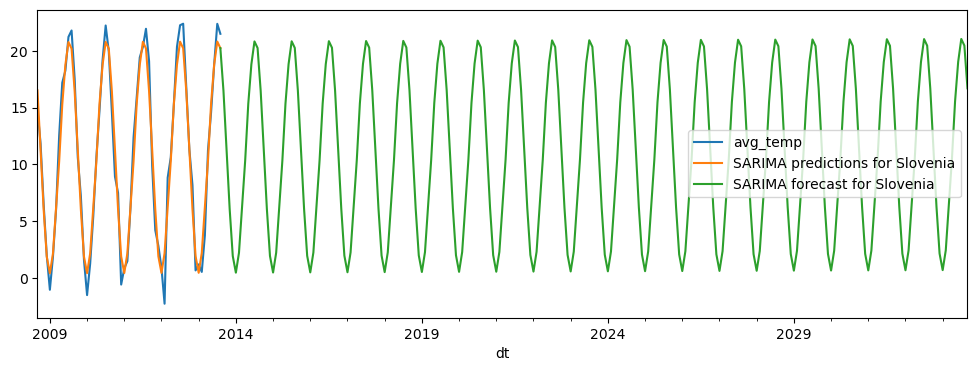

10 years Mean temperatures for Slovenia vs. Global average: 


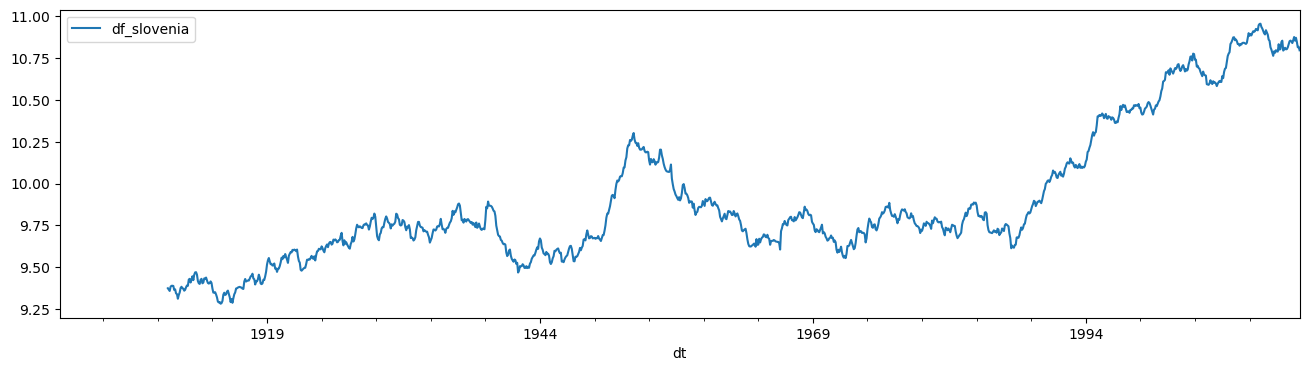

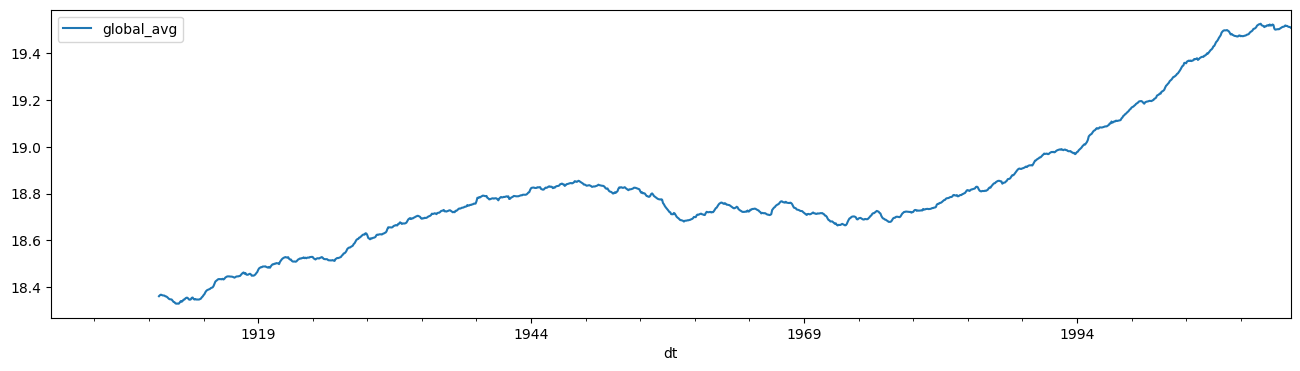

Yearly predictions average for Slovenia vs. Global average: 


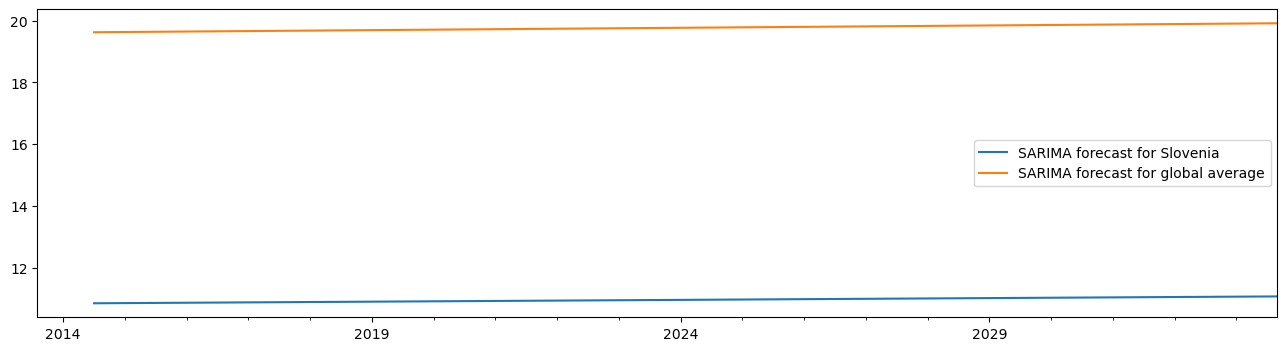



South Africa
Error:  0.61
Mean:  17.95


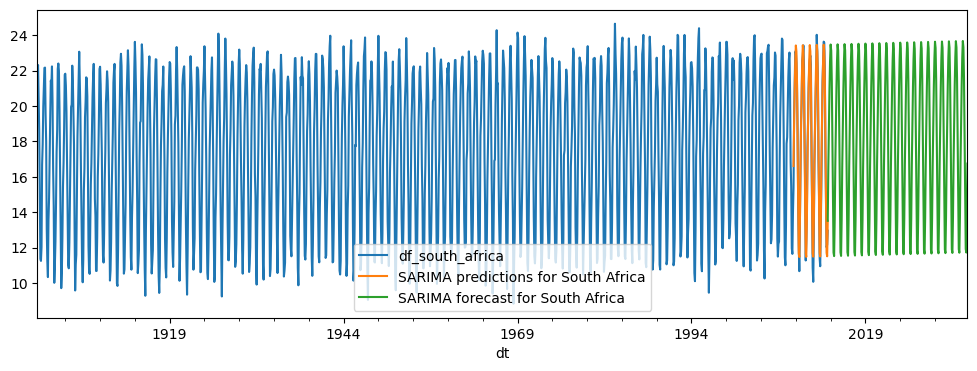

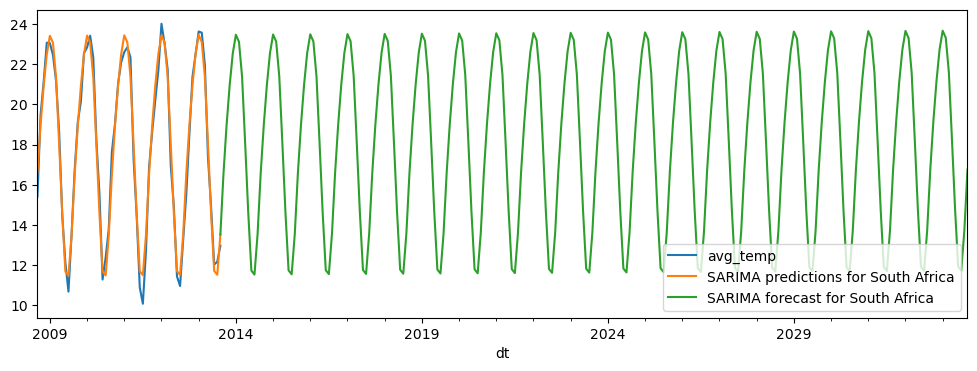

10 years Mean temperatures for South Africa vs. Global average: 


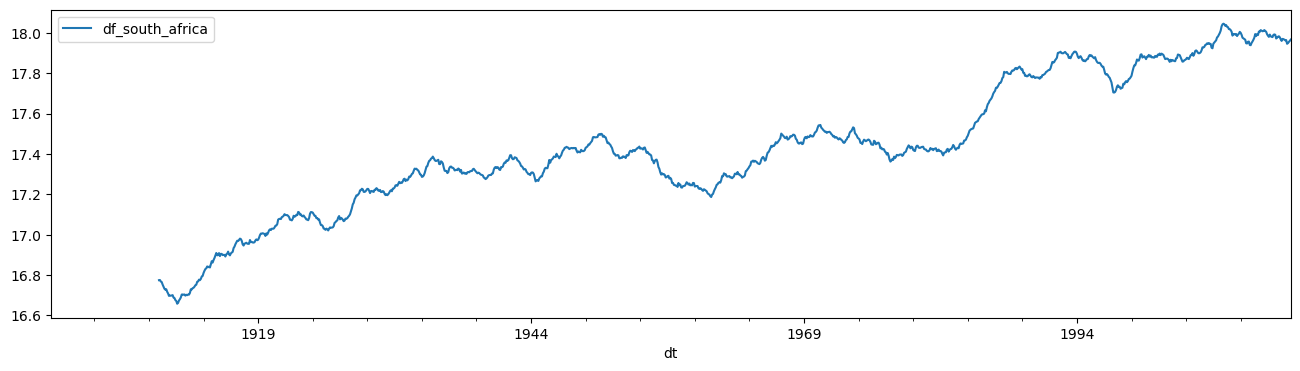

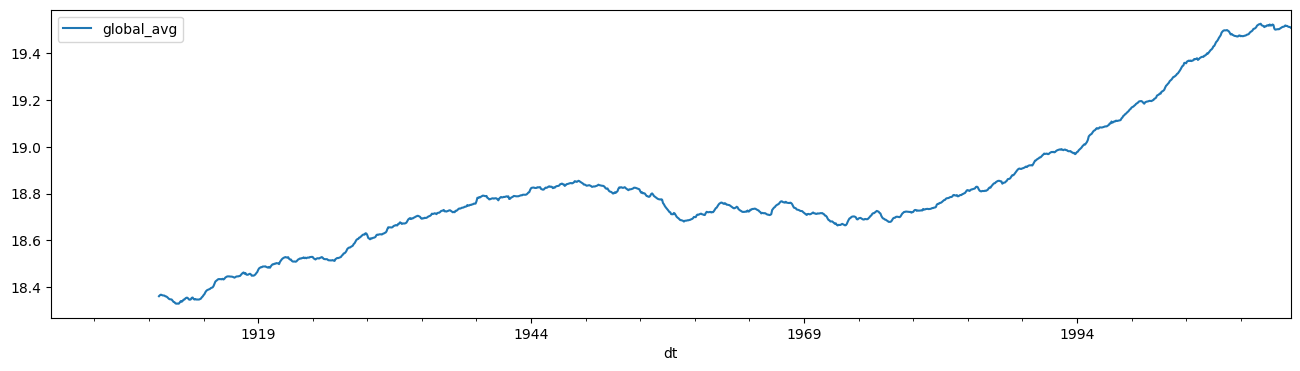

Yearly predictions average for South Africa vs. Global average: 


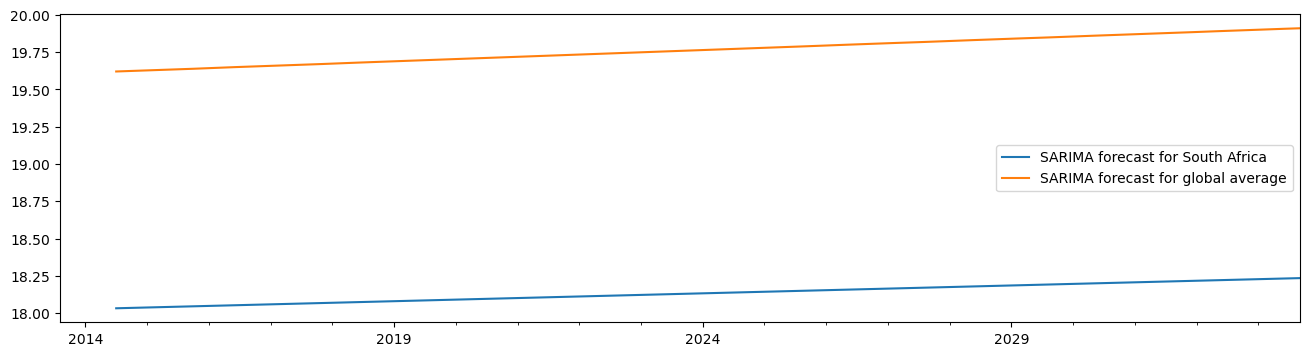



Switzerland
Error:  1.52
Mean:  7.96


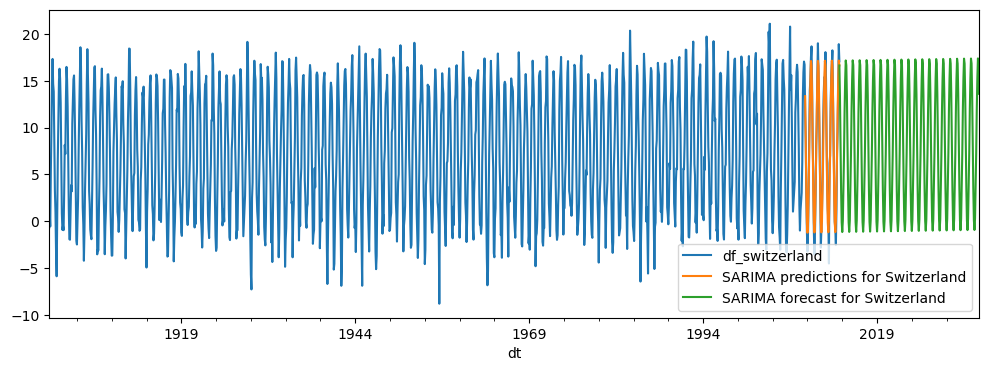

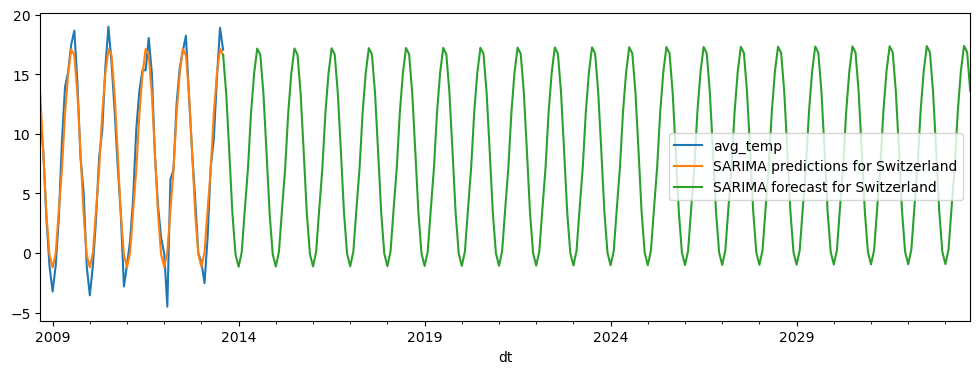

10 years Mean temperatures for Switzerland vs. Global average: 


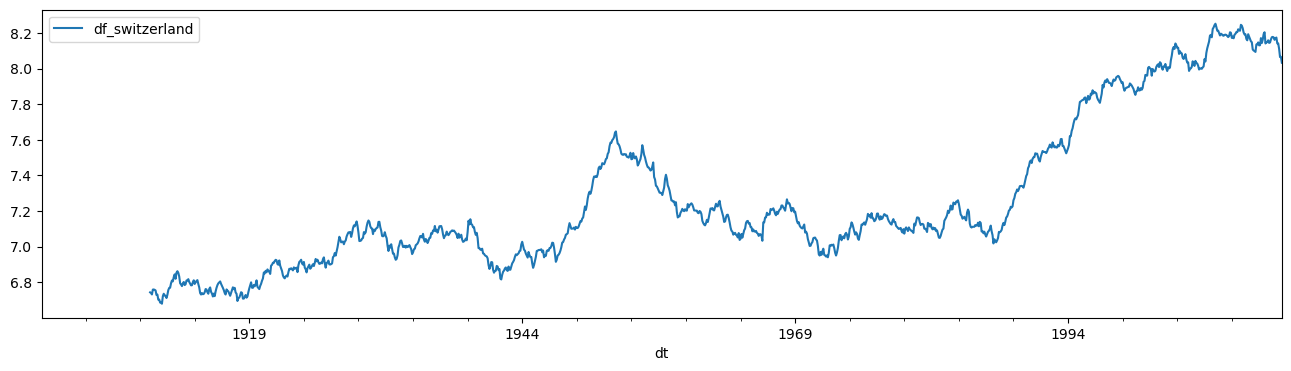

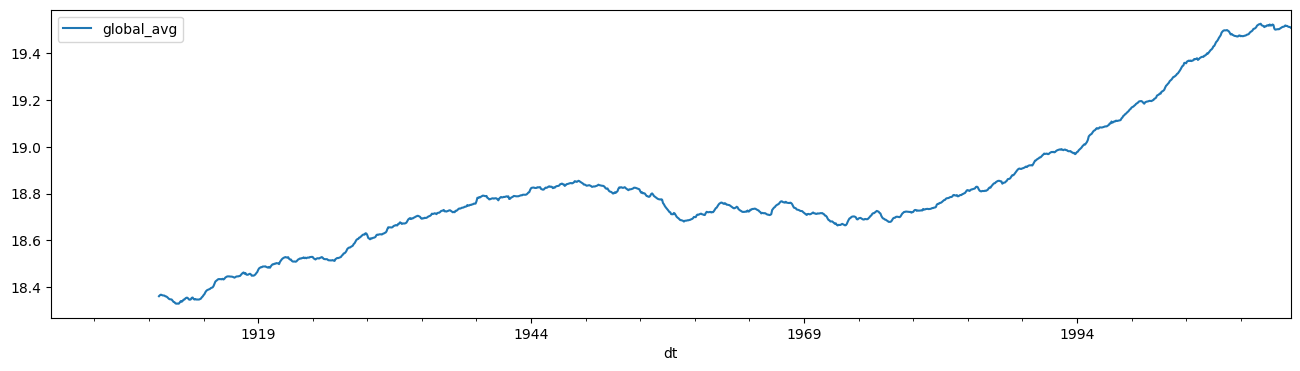

Yearly predictions average for Switzerland vs. Global average: 


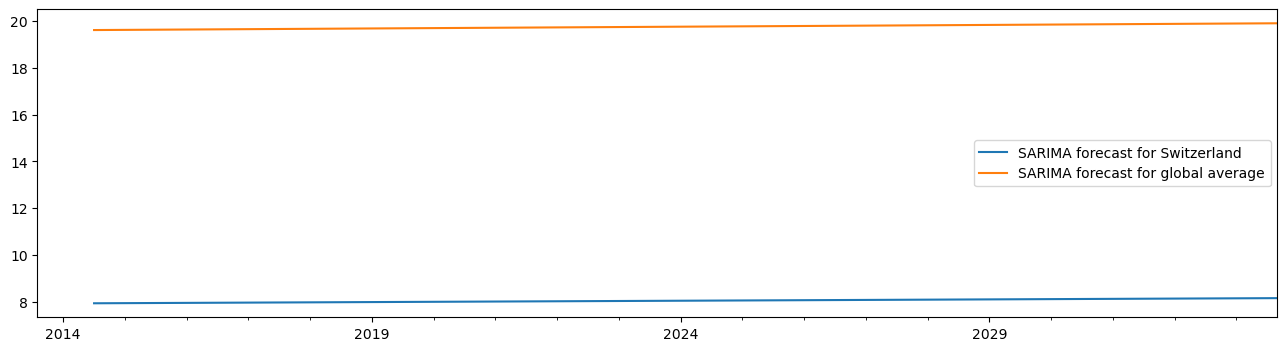

In [85]:
models_data = {}
to_export = {}

for i in range(len(all_countries)):
    country_df = all_countries[i]['avg_temp']
    country_name = all_countries[i]['country'].unique()[0]
    
    # Train-test
    train = all_countries[i].iloc[:-60]['avg_temp']
    test = all_countries[i].iloc[-60:]['avg_temp']
    
    # orders
    order = params[country_name]['order']
    seasonal_order = params[country_name]['seasonal_order']
    
    # create models
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    model.initialize_approximate_diffuse()
    results = model.fit(disp=0)
    
    # start, end
    start = len(train)
    end = len(train) + len(test) - 1
    
    # predictions & forecast for 20 years
    predictions = results.predict(start, end, typ='levels').rename(f"SARIMA predictions for {country_name}")
    fcast = results.predict(len(country_df)-1, len(country_df) + 240, typ='levels').rename(f"SARIMA forecast for {country_name}")
    
    # evaluation
    error = round(rmse(test, predictions), 2)
    mean = round(test.mean(), 2)
#     print(f'{country_name}: ', compare_error_mean(error, mean))
    print(country_name)
    print(f'Error: ', error)
    print(f'Mean: ', mean)
    
    # plots
    country_df.plot(legend=True, figsize=(12,4))
    predictions.plot(legend=True)
#     train.plot(legend=True)
    fcast.plot(legend=True)
    plt.show()
    
    test.plot(legend=True, figsize=(12,4))
    predictions.plot(legend=True)
#     train.plot(legend=True)
    fcast.plot(legend=True)
    plt.show() 
    
    # Plot mean for each 10yrs for existing data vs. global average
    print(f"10 years Mean temperatures for {country_name} vs. Global average: ")
    country_df.rolling(window=120).mean().plot(figsize=(16,4), legend=True)
    total_avg.rolling(window=120).mean().plot(figsize=(16,4), legend=True)
    plt.show()
    
    # Plot yearly mean of predictions vs. global average
    print(f"Yearly predictions average for {country_name} vs. Global average: ")
    fcast.rolling(window=12).mean().plot(figsize=(16,4), legend=True)
    g_fcast.rolling(window=12).mean().plot(figsize=(16,4), legend=True)
    plt.show()
    
    print()
    print()
    
    # Save all relevant info in dictionary
    models_data[country_name] = {
        'train': train,
        'test': test,
        'model': model,
        'results': results,
        'start': start,
        'end': end,
        'predictions': predictions,
        'forecast': fcast,
        'forecast_yearly_avg': fcast.rolling(window=12).mean(),
        '10_years_mean': country_df.rolling(window=120).mean(),
        'error': error,
        'mean': mean
    }
    
    to_export[country_name] = {
        f'df_{country_name}': country_df,
        f'train_{country_name}': train,
        f'test_{country_name}': test,
        f'predictions_{country_name}': predictions,
        f'forecast_{country_name}': fcast,
        f'forecast_yearly_avg_{country_name}': fcast.rolling(window=12).mean(),
        f'10_years_mean_{country_name}': country_df.rolling(window=120).mean(),
    }

In [51]:
# Adding in the Json file also the data about the total_avg temps

to_export['total_avg'] = {
    'df_total_avg': total_avg,
    'train_total_avg': g_train,
    'test_total_avg': g_test,
    'predictions_total_avg': g_predictions,
    'forecast_total_avg': g_fcast,
    'forecast_yearly_avg_total_avg': fcast.rolling(window=12).mean(),
    '10_years_mean_total_avg': country_df.rolling(window=120).mean()
}

In [67]:
# Combining all the DFs I need Into a list, and from there creating a DF

dfs_to_merge = []

for key1, value1 in to_export.items():
    for key2, value2 in value1.items():
#         new_col_name = key2.lower().replace(' ', '_').replace('(','').replace(')','')
#         print(value2.columns)
#         value2.rename(new_col_name, inplace=True)
        dfs_to_merge.append(value2)

In [68]:
df_tableau = pd.concat(dfs_to_merge, axis=1)

In [83]:
df_tableau['predictions_australia'].info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 1606 entries, 1900-01-01 to 2033-10-01
Freq: MS
Series name: predictions_australia
Non-Null Count  Dtype  
--------------  -----  
60 non-null     float64
dtypes: float64(1)
memory usage: 89.6 KB


In [70]:
df_tableau.to_csv('df_tableau.csv')

## Making forecasts for the future

In [ ]:
# Created a dictionary to group all the dataframes to replace the existing list (all_countries), otherwise it would be hard to loop

dct_all = {}

for i in range(len(all_countries)):
    country_name = all_countries[i]['country'].unique()[0]
    dct_all[country_name] = all_countries[i]

In [ ]:
# Writing a func to predict output the annual temp mean of the predictions

def predict_annual_avg(country_data):
    country = input('For which country would you like to have your predictions? ').title()
    print(country)
    user_input_year = input('And for which year? ')
    temp = round(country_data[country]['forecast_yearly_avg'].loc[f'{user_input}-12-01'], 2)
    return f'The yearly average temperature for {country} in {user_input_year} are an average temperature of {output}'

In [ ]:
predict_annual_avg(models_data)